<a href="https://colab.research.google.com/github/Irina-Na/EDA_and_CDA/blob/main/Highly_permeable_transformer_steel_EDA_CDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import datetime as dt
import calendar
import matplotlib
import scipy
import statsmodels

from matplotlib import pyplot as plt
from sklearn import preprocessing

from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Read and prepair datasets

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Dataset.xlsx')

df

,Индекс,Номер партии,Номер партии_АСУТП,Номер плавки,Номер рулона,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,Углерод_начало,Длина_Обезуглероживание,Толщина_средняя,Длина_ГП,Длина_МС,Длина_Н,Азот_конец,Азот_начало,Азот_среднее,Кислород_начало,N,Al,Номер_бригады,Поступление_в_технологическую_секцию,Выезд_из_технологической_секции,Длина__м,ЗВО,CO_Этап2_зона1,CO_Этап2_зона2,CO_Этап2_зона3,CO_Этап2_зона4,CO2_Этап1,Калиброванное_значение_CO2_Этап2_зона4,Si,Mn,Cu,NH3_Этап3_зона3,T_Этап3_зона4,Настройка_датчика_CO2_Этап2_зона4,Ni,...,T_Этап3_зона3,T_в_начале_нормализации,T_в_середине_нормализации_1,T_в_середине_нормализации_2,T_в_конце_нормализации,T_проход_1,T_проход_3,T_проход_5,T_проход_2,T_проход_4,Температура_полосы_на_выходе_реверсивного стана,ШОС,Ti,Длина_Азотирование,Толщина_МС,Точка_росы_Этап4_зона1,Точка_росы_Этап2_зона2,Точка_росы_Этап2_зона3,T_за_средней_клетью,T_конца_проката,T_рулона,Тренд_температуры_перед_реверсивным_станом,Толщина_перед_смоткой,C,Удельные_потери,Начало непрерывного отжига,Окончание непрерывного отжига,F,Cr,Водород_начало,Водород_среднее,CO2_Этап2_зона5,H2_Этап2_зона5,Точка_росы_Этап1_зона1,Точка_росы_Этап1_зона2,CO_Этап1_зона1,CO_Этап1_зона2,H2_Этап1,CO2_Этап2_зона1,CO2_Этап2_зона3
0,0,522350,580797,1717428,70,23.280000,2214.000000,55.600000,5111.880000,121.760000,0.0027,121.120000,25,46.320000,120,25.200000,0.023,0.022,0.0225,0.091,0.0083,0.028,1,2017-08-01 13:23:14,NaT,0.016000,3.5,1.73,1.15,0.46,0.21,0.11,-0.020000,3.315,0.14,0.01,0.150116,309,0.000000,0.01,...,771.615760,1097.403200,1098.003200,1091.095200,902.112800,135.691170,181.605608,199.750038,178.910380,191.527300,100,Melubir 6736/LI,0.002,3560,0.287,-19.860000,61.004480,59.753280,948.368000,922.787048,593.184381,364,"тренд 2,3",0.055,1.072,NaT,2017-08-01 14:07:58,0.024,0.11,2.4,1.7,1.22,69.7,NaN,63.680000,NaN,1.60,69.75,0.10,0.06
1,1,522350,580797,1717428,70,25.220000,2211.000000,60.233333,5104.953333,131.906667,0.0027,131.213333,25,47.680000,130,27.300000,0.023,0.022,0.0225,0.091,0.0083,0.028,1,2017-08-01 13:23:14,2017-08-01 14:07:58,0.017333,3.5,1.73,1.15,0.46,0.21,0.11,0.821471,3.315,0.14,0.01,0.756901,25,0.841471,0.01,...,771.830920,1097.436800,1098.036800,1091.044800,902.247200,136.562104,183.547782,200.214333,179.181220,193.175100,100,Melubir 6736/LI,0.002,3680,0.288,-19.860000,61.035147,59.690293,948.232000,922.812952,591.215619,364,"тренд 2,3",0.055,1.087,NaT,NaT,0.024,0.11,2.7,1.9,1.22,70.8,NaN,63.680000,NaN,1.60,69.75,0.10,0.06
2,2,522350,580797,1717428,70,27.160000,2208.000000,64.866667,5098.026667,142.053333,0.0027,141.306667,25,49.040000,140,29.400000,0.023,0.022,0.0225,0.091,0.0083,0.028,1,2017-08-01 13:23:14,2017-08-01 14:07:58,0.018667,3.5,1.73,1.15,0.46,0.21,0.11,0.889297,3.315,0.14,0.01,0.149549,290,0.909297,0.01,...,771.913920,1097.470400,1098.070400,1090.994400,902.381600,135.844343,183.523596,203.104308,179.271500,194.330723,102,Melubir 6736/LI,0.002,4052,0.286,-19.860000,60.997387,59.612160,948.096000,922.838857,589.246857,363,"тренд 2,3",0.055,1.070,NaT,NaT,0.024,0.11,3.3,2.2,1.25,69.9,NaN,63.678693,NaN,1.60,69.75,0.10,0.06
3,3,522350,580797,1717428,70,29.100000,2205.000000,69.500000,5091.100000,152.200000,0.0027,151.400000,25,50.400000,150,31.500000,0.023,0.022,0.0225,0.091,0.0083,0.028,1,2017-08-01 13:23:14,2017-08-01 14:07:58,0.020000,3.5,1.73,1.15,0.46,0.21,0.11,0.121120,3.315,0.14,0.01,0.994824,231,0.141120,0.01,...,771.961000,1097.504000,1098.104000,1090.944000,902.516000,135.126582,183.784710,205.981120,179.271500,196.103200,103,Melubir 6736/LI,0.002,4576,0.286,-19.837600,60.981400,59.561400,948.000000,922.776190,587.416190,361,"тренд 2,3",0.055,1.075,NaT,NaT,0.024,0.11,1.9,1.5,2.81,69.1,NaN,63.668600,NaN,1.60,69.75,0.10,0.06
4,4,522350,580797,1717428,70,31.040000,2202.000000,74.133333,5084.173333,162.346667,0.0027,161.493333,25,51.760000,160,33.600000,0.023,0.022,0.0225,0.091,0.0083,0.028,1,NaT,2017-08-01 14:07:58,0.021333,3.5,1.73,1.15,0.46,0.21,0.11,-0.776802,3.315,0.14,0.01,-0.976552,235,-0.756802,0.01,...,77

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Columns: 120 entries, Индекс to CO2_Этап2_зона3
dtypes: datetime64[ns](4), float64(100), int64(14), object(2)
memory usage: 11.7+ MB


In [ ]:
df.describe()

,Индекс,Номер партии,Номер партии_АСУТП,Номер плавки,Номер рулона,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,Углерод_начало,Длина_Обезуглероживание,Толщина_средняя,Длина_ГП,Длина_МС,Длина_Н,Азот_конец,Азот_начало,Азот_среднее,Кислород_начало,N,Al,Номер_бригады,Длина__м,ЗВО,CO_Этап2_зона1,CO_Этап2_зона2,CO_Этап2_зона3,CO_Этап2_зона4,CO2_Этап1,Калиброванное_значение_CO2_Этап2_зона4,Si,Mn,Cu,NH3_Этап3_зона3,T_Этап3_зона4,Настройка_датчика_CO2_Этап2_зона4,Ni,Кислород_конец,Кислород_среднее,...,T_Этап2_зона6,T_Этап2_зона7,T_Этап3_зона1,T_Этап3_зона2,T_Этап3_зона3,T_в_начале_нормализации,T_в_середине_нормализации_1,T_в_середине_нормализации_2,T_в_конце_нормализации,T_проход_1,T_проход_3,T_проход_5,T_проход_2,T_проход_4,Температура_полосы_на_выходе_реверсивного стана,Ti,Длина_Азотирование,Толщина_МС,Точка_росы_Этап4_зона1,Точка_росы_Этап2_зона2,Точка_росы_Этап2_зона3,T_за_средней_клетью,T_конца_проката,T_рулона,Тренд_температуры_перед_реверсивным_станом,C,Удельные_потери,F,Cr,Водород_начало,Водород_среднее,CO2_Этап2_зона5,H2_Этап2_зона5,Точка_росы_Этап1_зона1,Точка_росы_Этап1_зона2,CO_Этап1_зона1,CO_Этап1_зона2,H2_Этап1,CO2_Этап2_зона1,CO2_Этап2_зона3
count,12791.000000,12791.000000,12791.000000,1.279100e+04,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,1.279100e+04,12791.000000,12791.000000,12791.000000,1.279100e+04,12791.000000,12791.000000,...,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,12791.000000,5671.000000,7120.000000,1315.000000,11476.000000,12791.000000,12791.000000,12791.000000
mean,6395.000000,522363.075365,580805.018138,1.717428e+06,41.332265,735.243324,1092.121597,1749.815388,2504.335596,3742.866852,0.003309,3725.768718,24.541787,548.489827,3690.181378,736.991503,0.022509,0.022879,0.022694,0.078361,0.007511,0.029056,1.916738,0.509686,3.390978,1.680891,1.112086,0.442210,0.213710,0.095109,-0.020061,3.314503,0.143204,1.000000e-02,0.014216,500.963177,0.000075,1.000000e-02,0.081098,0.079730,...,840.015252,840.019702,769.998723,770.009468,769.978269,1098.419497,1098.564210,1091.619851,905.500405,133.726499,219.667195,204.700834,206.967023,230.037728,102.349621,0.002216,3359.340161,0.286456,-17.245248,60.227283,58.495085,952.169263,924.533208,564.038523,348.883512,0.054450,1.214428,0.024445,0.116101,2.255007,3.397232,2.003105,70.004886,63.359672,63.216574,1.570991,1.541203,69.031543,0.089100,0.044719
std,3692.587981,8.543076,7.844949,3.800574e+00,19.326995,408.652924,631.079324,972.714686,1448.081977,2089.420728,0.000770,2081.387976,1.011405,288.111988,2061.213914,426.759873,0.001169,0.001520,0.000996,0.008251,0.000472,0.000912,0.862036,0.283189,0.313461,0.046753,0.075733,0.047472,0.036463,0.008193,0.707187,0.027285,0.007336,2.230942e-15,0.706083,289.407443,0.707146,2.230942e-15,0.006075,0.006587,...,0.355338,0.442394,0.658645,0.804350,0.718967,2.817714,2.608075,3.356378,2.089861,23.218648,19.502678,19.994497,16.207315,20.617041,10.004075,0.000411,2971.502960,0.008711,6.228700,0.626772,1.208106,6.396713,3.911231,7.630293,11.814485,0.001248,0.270874,0.000497,0.004877,0.720063,1.407279,0.581622,1.157503,0.329969,0.310730,0.028883,0.085113,4.927335,0.008611,0.007113
min,0.000000,522350.000000,580792.000000,1.717423e+06,10.000000,20.214286,0.000000,47.357143,0.000000,99.786325,0.002200,99.430199,23.000000,44.142857,100.000000,25.000000,0.020000

In [ ]:
df.astype('object').describe()

,Индекс,Номер партии,Номер партии_АСУТП,Номер плавки,Номер рулона,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,Углерод_начало,Длина_Обезуглероживание,Толщина_средняя,Длина_ГП,Длина_МС,Длина_Н,Азот_конец,Азот_начало,Азот_среднее,Кислород_начало,N,Al,Номер_бригады,Поступление_в_технологическую_секцию,Выезд_из_технологической_секции,Длина__м,ЗВО,CO_Этап2_зона1,CO_Этап2_зона2,CO_Этап2_зона3,CO_Этап2_зона4,CO2_Этап1,Калиброванное_значение_CO2_Этап2_зона4,Si,Mn,Cu,NH3_Этап3_зона3,T_Этап3_зона4,Настройка_датчика_CO2_Этап2_зона4,Ni,...,T_Этап3_зона3,T_в_начале_нормализации,T_в_середине_нормализации_1,T_в_середине_нормализации_2,T_в_конце_нормализации,T_проход_1,T_проход_3,T_проход_5,T_проход_2,T_проход_4,Температура_полосы_на_выходе_реверсивного стана,ШОС,Ti,Длина_Азотирование,Толщина_МС,Точка_росы_Этап4_зона1,Точка_росы_Этап2_зона2,Точка_росы_Этап2_зона3,T_за_средней_клетью,T_конца_проката,T_рулона,Тренд_температуры_перед_реверсивным_станом,Толщина_перед_смоткой,C,Удельные_потери,Начало непрерывного отжига,Окончание непрерывного отжига,F,Cr,Водород_начало,Водород_среднее,CO2_Этап2_зона5,H2_Этап2_зона5,Точка_росы_Этап1_зона1,Точка_росы_Этап1_зона2,CO_Этап1_зона1,CO_Этап1_зона2,H2_Этап1,CO2_Этап2_зона1,CO2_Этап2_зона3
count,12791,12791,12791,12791,12791,12791.0,12791.0,12791.000000,12791.0,12791.000000,12791.0000,12791.000000,12791,12791.0,12791,12791.000000,12791.000,12791.000,12791.000,12791.000,12791.0000,12791.00,12791,7978,9485,12791.0,12791.0,12791.0,12791.00,12791.00,12791.0,12791.0,12791.00000,12791.000,12791.00,12791.00,12791.000000,12791,12791.000000,12791.00,...,12791.00,12791.0,12791.0,12791.0,12791.0,12791.0000,12791.0000,12791.0000,12791.0000,12791.0000,12791,12791,12791.000,12791,12791.000,12791.00,12791.00,12791.00,12791.0,12791.000000,12791.0,12791,12791,12791.000,12791.000,4813,3306,12791.000,12791.00,12791.0,12791.0,12791.00,12791.0,5671.00,7120.00,1315.00,11476.00,12791.0,12791.00,12791.00
unique,12791,18,18,5,12,12711.0,12708.0,12737.000000,12728.0,12760.000000,13.0000,12757.000000,4,11886.0,759,12614.000000,6.000,6.000,8.000,13.000,4.0000,3.00,3,5,5,11104.0,3.0,391.0,508.00,292.00,312.0,148.0,12791.00000,5.000,2.00,1.00,8034.000000,999,12791.000000,1.00,...,11902.00,11787.0,11466.0,11901.0,11886.0,10223.0000,8936.0000,12184.0000,8139.0000,10648.0000,86,5,2.000,100,79.000,8184.00,10115.00,9561.00,8423.0,11910.000000,12360.0,97,6045,4.000,1183.000,5,5,2.000,2.00,26.0,58.0,201.00,41.0,2877.00,3512.00,45.00,376.00,618.0,102.00,66.00
top,12790,522354,580798,1717425,40,1435.0,8.0,1811.712598,0.0,3760.892608,0.0027,3826.964286,24,1050.0,3450,708.955224,0.022,0.022,0.023,0.078,0.0075,0.03,1,2017-08-01 12:39:24,2017-08-01 13:23:14,1.0,3.5,1.7,1.11,0.44,0.2,0.1,-1.00256,3.333,0.14,0.01,0.898219,596,0.183923,0.01,...,770.53,1098.9,1098.1,1090.9,906.7,133.1505,221.2968,245.7967,214.0997,257.1865,103,Melubir 6733/LI,0.002,3212,0.288,-19.86,60.87,57.64,956.0,919.833333,561.0,349,"тренд_2,3",0.055,1.076,2017-08-01 12:39:24,2017-08-01 13:23:14,0.024,0.12,2.5,3.3,2.73,69.5,63.51,63.33,1.58,1.53,69.6,0.09,0.04
freq,1,758,758,3648,2181,5.0,15.0,4.000000,14.0,4.000000,2186.0000,4.000000,4335,15.0,21,4.000000,4326.000,4226.000,2770.000,1445.000,4156.0000,5697.00,5329,2299,2626,18.0,7156.0,1214.0,1090.00,1900.00,1693.0,5715.0,1.00000,3648.000,10742.00,12791.00,7.000000,30,1.000000,12791.00,...,91.00,45.0,55.0,50.0,18.0,8.0000,7.0000,5.0000,9.0000,5.0000,599,3648,10031.000,166,3934.000,4420.00,66.00,49.00,381.0,32.000000,26.0,620,1786,5875.000,72.000,1349,1022,7094.000,7804.00,569.0,384.0,92.00,356.0,296.00,290.00,339.00,1524.00,387.0,4759.00,5569.00


Exist many categorical features (with a low count of unique values).

Exist n/a values in Точка_росы_Этап1_зона1,	Точка_росы_Этап1_зона2,  CO_Этап1_зона1,	CO_Этап1_зона2  and datetime values

Will not delete rows with nan data before chek correlation with target feature.
For future use we can delete columns with many nan data and delete rows for less nan data if the correlation with this feature is higth.

Exist also non types columns and 4 datetime columns about timedelta only. 
 
### Prepaire:

In [ ]:
df.select_dtypes('object')

,ШОС,Толщина_перед_смоткой
0,Melubir 6736/LI,"тренд 2,3"
1,Melubir 6736/LI,"тренд 2,3"
2,Melubir 6736/LI,"тренд 2,3"
3,Melubir 6736/LI,"тренд 2,3"
4,Melubir 6736/LI,"тренд 2,3"
...,...,...
12786,Melubir 6731/LI,"тредн2,3112691771"
12787,Melubir 6731/LI,"тредн2,3084518828"
12788,Melubir 6731/LI,"тредн2,3056345886"
12789,Melubir 6731/LI,"тредн2,3028172943"


In [ ]:
print(df['ШОС'].unique())
shos = pd.CategoricalDtype(categories=df['ШОС'].unique(), ordered=False)
df['ШОС']= df['ШОС'].astype(shos)

['Melubir 6736/LI' 'Melubir 6733/LI' 'Melubir 6739/LI' 'Melubir 6738/LI'
 'Melubir 6731/LI']


In [ ]:
import re
df['Толщина_перед_смоткой']=df['Толщина_перед_смоткой'].apply(lambda x: float(re.findall('\d+.\d+', x.replace(',', '.') )[0]  ) )
df['Толщина_перед_смоткой']

0        2.300000
1        2.300000
2        2.300000
3        2.300000
4        2.300000
           ...   
12786    2.311269
12787    2.308452
12788    2.305635
12789    2.302817
12790    2.300000
Name: Толщина_перед_смоткой, Length: 12791, dtype: float64

In [ ]:
df['Время_проведенное_в_технологической_секции' ]= df['Выезд_из_технологической_секции' ]-df['Поступление_в_технологическую_секцию']
df.drop(['Выезд_из_технологической_секции', 'Поступление_в_технологическую_секцию'], axis=1,   inplace=True)
df['Время_проведенное_в_технологической_секции' ].min(), df['Время_проведенное_в_технологической_секции' ].max()
df['Время_проведенное_в_технологической_секции' ]=df['Время_проведенное_в_технологической_секции' ]/ np.timedelta64(1,'m')
df['Время_проведенное_в_технологической_секции' ]

0              NaN
1        44.733333
2        44.733333
3        44.733333
4              NaN
           ...    
12786    45.916667
12787          NaN
12788          NaN
12789    45.916667
12790    45.916667
Name: Время_проведенное_в_технологической_секции, Length: 12791, dtype: float64

In [ ]:
df['Время_нерперывного_отжига' ]= df['Окончание непрерывного отжига' ]-df['Начало непрерывного отжига']
df.drop(['Окончание непрерывного отжига', 'Начало непрерывного отжига'], axis=1,   inplace=True)
print(df['Время_нерперывного_отжига' ].min(), df['Время_нерперывного_отжига' ].max())
df['Время_нерперывного_отжига' ]=df['Время_нерперывного_отжига' ]/ np.timedelta64(1,'m')
df['Время_нерперывного_отжига' ]

0 days 00:43:50 0 days 00:45:55


0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
12786          NaN
12787          NaN
12788    45.916667
12789          NaN
12790          NaN
Name: Время_нерперывного_отжига, Length: 12791, dtype: float64

### Group and order parameters by stages:

In [ ]:
param=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Parameters.xlsx')
param

,Название параметра,Этап обработки,Описание,Номер пп
0,Длина_ГП,Горячий прокат,Фактическая длина на этапе горячей прокатки,2
1,T_за_средней_клетью,Горячий прокат,Замеры температур,2
2,T_конца_проката,Горячий прокат,Замеры температур,2
3,T_рулона,Горячий прокат,Замеры температур,2
4,Толщина_перед_смоткой,Горячий прокат,Замер толщины,2
...,...,...,...,...
115,T_проход_5,Холодный прокат,Замер температуры рулона,4
116,T_проход_2,Холодный прокат,Замер температуры рулона,4
117,T_проход_4,Холодный прокат,Замер температуры рулона,4
118,Температура_полосы_на_выходе_реверсивного стана,Холодный прокат,Замер температуры рулона,4


In [ ]:
#Add new parameters, delete uselessly
param=param.replace('Выезд_из_технологической_секции', 'Время_проведенное_в_технологической_секции', regex=True)
param=param.replace('Окончание непрерывного отжига', 'Время_нерперывного_отжига', regex=True)
param=param[~param['Название параметра'].isin(['Поступление_в_технологическую_секцию', 'Начало непрерывного отжига'])]
print (param['Этап обработки'].unique())
#param[param['Этап обработки'].isin(['Обезуглероживание']) ]


['Горячий прокат' 'Магнитные свойства' 'Нормализация' 'Обезуглероживание'
 'Общие данные' 'Химия плавки' 'Химия итог' 'Холодный прокат']


In [ ]:
param['Этап_обезуглероживания']=param['Название параметра'].apply(lambda x: 0 if 'Этап' not in x else int(re.findall('Этап\d', x)[0][4:])  )
param['Зона_обезуглероживания']=param['Название параметра'].apply(lambda x: 0 if 'зона' not in x else int(re.findall('зона\d', x)[0][4:])  )
param.sort_values(['Номер пп', 'Этап_обезуглероживания',	'Зона_обезуглероживания'], ascending=[True, True, True], inplace=True, ignore_index=True)
param[48:100]

,Название параметра,Этап обработки,Описание,Номер пп,Этап_обезуглероживания,Зона_обезуглероживания
48,CO2_Этап1,Обезуглероживание,"Замеры с различных датчиков на этапе ""обезугле...",5,1,0
49,H2_Этап1,Обезуглероживание,"Замеры с различных датчиков на этапе ""обезугле...",5,1,0
50,T_Этап1_зона1,Обезуглероживание,"Замеры с различных датчиков на этапе ""обезугле...",5,1,1
51,Точка_росы_Этап1_зона1,Обезуглероживание,"Замеры с различных датчиков на этапе ""обезугле...",5,1,1
52,CO_Этап1_зона1,Обезуглероживание,"Замеры с различных датчиков на этапе ""обезугле...",5,1,1
53,T_Этап1_зона2,Обезуглероживание,"Замеры с различных датчиков на этапе ""обезугле...",5,1,2
54,Точка_росы_Этап1_зона2,Обезуглероживание,"Замеры с различных датчиков на этапе ""обезугле...",5,1,2
55,CO_Этап1_зона2,Обезуглероживание,"Замеры с различных датчиков на этапе ""обезугле...",5,1,2
56,T_Этап1_зона3,Обезуглероживание,"Замеры с различных датчиков на этапе ""обезугле...",5,1,3
57,T_Этап1_зона4,Обезуглероживание,"Замеры с различных датчиков на этапе ""обезугле...",5,1,4


In [ ]:
df=df[param['Название параметра'].to_numpy()]
df.columns==param['Название параметра'].to_numpy()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Dataset ordered in the stages order

In [ ]:
#Made dict of paramerts on each stage
stages = {}
#Use stages range from tasks description:
for s in { 'Химия плавки',  'Горячий прокат', 'Нормализация', 'Холодный прокат', 'Обезуглероживание', 'Химия итог'}:
  stages[s]= param['Название параметра'][param['Этап обработки'].isin([s])].to_list()

In [ ]:
decarbonization = pd.DataFrame(param['Название параметра'][param['Этап обработки'].isin(['Обезуглероживание']) ])
decarbonization['Этап_обезуглероживания']=decarbonization['Название параметра'].apply(lambda x: 0 if 'Этап' not in x else int(re.findall('Этап\d', x)[0][4:])  )
decarbonization['Зона_обезуглероживания']=decarbonization['Название параметра'].apply(lambda x: 0 if 'зона' not in x else int(re.findall('зона\d', x)[0][4:])  )
decarbonization.sort_values(['Этап_обезуглероживания',	'Зона_обезуглероживания'], ascending=[True, True], inplace=True, ignore_index=True)


In [ ]:
list(range(1,6))

[1, 2, 3, 4, 5]

In [ ]:
#numerical features for correlation:
num_param=param['Название параметра'][param['Номер пп'].isin(list(range(2,6)))].to_list()


# **Statement**

Для отбора признаков мы можем использовать фильтры и обертки, а также их стеки (гибридные методы). В рамках этого ТЗ я буду оперировать только фильтрами в связи с ограничениями производительности.


Далее в двух разделах будут проанализированы признаки по этапам, выдвинуты гипотезы и проверены критериями (Хи-квадрат для категориальных и Стьюдентом для непрерывных числовых). Значения непосредстенно вклада будут оценены практически по CFS (Correlation-based feature selection, отбор признаков на основе корреляции). Однако у нас есть различные типы признаков и тут получится немного сложнее (разыне подходы к оценке), в добавок сначала мы оценим корреляцию с целевым показателем, затем будет продложено оценить коллинеарность и исключить часть признаков по этому показателю.

Создадим сразу список бесполезных параметров на основании Дисперсии. Было показано, что оценка дисперсии признака может быть эффективным способом отбора признаков. Как правило признаки с почти нулевой дисперсией не являются значимыми, и их можно удалить.

In [ ]:
selector = VarianceThreshold()
selector.fit_transform(df)
selector= selector.get_feature_names_out(df.columns)
unuseful_param=[i for i in df.columns if i not in selector]
unuseful_param

ValueError: ignored

In [ ]:
"""df.drop(columns=unuseful_param, inplace=True)
param=param[~param['Название параметра'].isin(unuseful_param)]
#Made dict of paramerts on each stage
stages = {}
#Use stages range from tasks description:
for s in { 'Химия плавки',  'Горячий прокат', 'Нормализация', 'Холодный прокат', 'Обезуглероживание', 'Химия итог'}:
  stages[s]= param['Название параметра'][param['Этап обработки'].isin([s])].to_list()
"""

# Medians analysis and visualisation

### Made Удельные_потери_кат feature

Стоит помнить о том, что качество продукции однозначно определеяется величиной удельных магнитных потерь, соответственно мы можем представить целевой признак как биноминальную величину:

In [ ]:
df['Удельные_потери_кат']=df['Удельные_потери']< 1.1
df.loc[:,'Удельные_потери_кат']=df['Удельные_потери_кат'].astype(int)
cat = pd.CategoricalDtype(categories=[0, 1], ordered=False)
df.loc[:,'Удельные_потери_кат']=df['Удельные_потери_кат'].astype(cat)
df['Удельные_потери_кат'].value_counts()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


0    6551
1    6240
Name: Удельные_потери_кат, dtype: int64

Больше половины продукции некачественная, зато баланс классов). 

## Поcмотрим как отличаются средние показатели для качественной и не качественной продукции

Эту предвариательную грубую оценку мы можем применить не только к непрерывных числовым признакам, но и почти ко всем остальным признакам с небольшим числом уникальных значений, поскольку хоть они и имеют небольшое число ранжированных категории, но по сути имеют количественную, числовую природу. В следствии этого оценка средних, медианы и масштабирование будет иметь верный смысл. Кроме ШОС - это не числовой категориальынй параметр. Удалим его из анализа

In [ ]:
# Рассмотрим только этапов обработки/воздействия + химические показатели материала на этапе плавки:
useful_param=list(param['Название параметра'][param['Номер пп'].isin(list(range(1,6)))].unique())
useful_param.remove('ШОС')
for i in unuseful_param:
  useful_param.remove(i)
#num_param=[i for i in useful_param if df[i].nunique()>66] 
#cat_param=[i for i in useful_param if df[i].nunique()<66] 

In [ ]:
param['Этап обработки'][param['Номер пп'].isin(list(range(1,6)))].unique()

array(['Химия плавки', 'Горячий прокат', 'Нормализация',
       'Холодный прокат', 'Обезуглероживание'], dtype=object)

Необходимо провести масштабирование признаков и  посмотреть на  графики отличия средних.

Выбирая между MinMaxScaler и StandartScaler, будем ипользовать последний, поскольку он более устойчив к выбросам, которых у нас достаточно много, как будет видно на этапах анализа ниже. 

In [ ]:
scaler = StandardScaler()

df_scaler = pd.DataFrame(columns=df[useful_param].columns,  data=scaler.fit_transform(df[useful_param]) )
#df_scaler=pd.concat([  df_scaler, df['Удельные_потери_кат']], axis=1)

df_scaler

,N,Al,Si,Mn,Sn,S,Ti,C,F,Cr,Длина_ГП,T_за_средней_клетью,T_конца_проката,T_рулона,Толщина_перед_смоткой,Длина_Н,Номер_бригады,T_в_начале_нормализации,T_в_середине_нормализации_1,T_в_середине_нормализации_2,T_в_конце_нормализации,Длина_1,Длина_2,Длина_3,Длина_4,Длина_5,T_проход_1,T_проход_3,T_проход_5,T_проход_2,T_проход_4,Температура_полосы_на_выходе_реверсивного стана,Тренд_температуры_перед_реверсивным_станом,Длина_Обезуглероживание,Время_проведенное_в_технологической_секции,Датчик_механических_свойств,Длина_Азотирование,Время_нерперывного_отжига,H2_Этап1,T_Этап1_зона1,...,CO_Этап1_зона2,T_Этап1_зона3,T_Этап1_зона4,T_Этап1_зона5,CO2_Этап2_зона1,H2_Этап2_зона1,T_Этап2_зона1,CO_Этап2_зона2,H2_Этап2_зона2,T_Этап2_зона2,Точка_росы_Этап2_зона2,CO_Этап2_зона3,H2_Этап2_зона3,T_Этап2_зона3,Точка_росы_Этап2_зона3,CO_Этап2_зона4,Калиброванное_значение_CO2_Этап2_зона4,Настройка_датчика_CO2_Этап2_зона4,H2_Этап2_зона4,T_Этап2_зона4,CO_Этап2_зона5,T_Этап2_зона5,CO2_Этап2_зона5,H2_Этап2_зона5,T_Этап2_зона6,T_Этап2_зона7,H2_Этап3_зона1,T_Этап3_зона1,H2_Этап3_зона2,NH3_Этап3_зона2,T_Этап3_зона2,NH3_Этап3_зона3,T_Этап3_зона3,T_Этап3_зона4,H2_Этап4_зона1,Т_Этап4_зона1,Точка_росы_Этап4_зона1,Т_Этап4_зона2,Т_Этап5_зона1,Т_Этап5_зона2
0,1.671609,-1.157042,0.018198,-0.436745,0.693756,-0.783716,-0.524545,0.440691,-0.896143,-1.250947,-1.743036,-0.594276,-0.446465,3.819905,0.493131,-1.667962,-1.063499,-0.360696,-0.215114,-0.156321,-1.621035,-1.742288,1.777783,-1.741807,1.800759,-1.733135,0.084619,-1.951685,-0.247618,-1.731178,-1.867966,-0.234876,1.279538,-1.731916,NaN,-3.131856,0.067531,NaN,0.145816,0.177998,...,0.690835,-0.939674,0.028967,-1.176349,1.265791,1.318242,-0.175264,0.500646,1.315519,-0.145939,1.240048,0.374750,0.853879,1.183571,1.041502,-0.101752,0.000086,-0.000106,-0.132666,-0.490670,0.042125,-1.637787,-1.346468,-0.263410,-1.387499,-1.569029,1.96705,0.670003,0.294878,0.800149,-0.669322,0.192478,2.277650,-0.663323,1.648235,-0.080937,-0.419807,-0.497596,1.124587,0.642613
1,1.671609,-1.157042,0.018198,-0.436745,0.693756,-0.783716,-0.524545,0.440691,-0.896143,-1.250947,-1.738315,-0.615537,-0.439842,3.561876,0.493131,-1.663041,-1.063499,-0.348771,-0.202230,-0.171337,-1.556722,-1.737541,1.773029,-1.737044,1.795975,-1.728279,0.122131,-1.852096,-0.224396,-1.714466,-1.788039,-0.234876,1.279538,-1.727067,-0.306235,-2.186208,0.107916,NaN,0.145816,0.176152,...,0.690835,-1.023940,0.117111,-1.176349,1.265791,1.318242,-0.146054,0.500646,1.315519,-0.134861,1.288978,0.374750,0.853879,0.804202,0.989363,-0.101752,1.190017,1.189895,-0.132666,-0.490670,0.034777,-1.670840,-1.346468,0.686948,-1.381908,-1.493347,1.96705,0.670003,-0.423202,0.800149,-0.647722,1.051880,2.576924,-1.644677,1.648235,-0.077826,-0.419807,-0.537894,1.146860,0.645630
2,1.671609,-1.157042,0.018198,-0.436745,0.693756,-0.783716,-0.524545,0.440691,-0.896143,-1.250947,-1.733594,-0.636799,-0.433218,3.303847,0.493131,-1.658120,-1.063499,-0.336846,-0.189346,-0.186354,-1.492409,-1.732793,1.768275,-1.732280,1.791192,-1.723422,0.091217,-1.853336,-0.079851,-1.708895,-1.731985,-0.034949,1.194893,-1.722217,-0.306235,-1.347481,0.233110,NaN,0.145816,0.154828,...,0.690835,-1.022563,0.222203,-1.176349,1.265791,1.318242,-0.122469,0.500646,1.315519,-0.052932,1.228730,0.374750,0.853879,0.937490,0.924687,-0.101752,1.285931,1.285815,-0.132666,-0.490670,0.027988,-1.640237,-1.294886,-0.090618,-1.692348,-1.657340,1.96705,0.670003,-1.474302,0.800149,-0.563129,0.191676,2.692372,-0.728977,1.648235,-0.055297,-0.419807,-0.508830,1.148499,0.686973
3,1.671609,-1.157042,0.018198,-0.436745,0.693756,-0.783716,-0.524545,0.440691,-0.896143,-1.250947,-1.728874,-0.651808,-0.449241,3.063917,0.493131,-1.653199,-1.063499,-0.324920,-0.176463,-0.201371,-1.428096,-1.728046,1.763521,-1.727517,1.786408,-1.718566,0.060302,-1.839947,0.064034,-1.708895,-1.646010,0.065014,1.025602,-1.717368,-0.306235,-1.515930,0.409459,NaN,0.145816,0.082740,...,0.690835,-1.020777,0.282003,-1.176349,1.265791,1.318242,-0.066328,0.500646,1.315519,-0.016028,1.

Будем смотреть также на медианные значения каждого параметра, чтобы меньше учитывать вклад выбросов

                               0         1
Длина_ГП                0.026287 -0.051080
T_за_средней_клетью    -0.136867  0.305127
T_конца_проката        -0.397473  0.307837
T_рулона                0.005300 -0.064027
Толщина_перед_смоткой   0.220807 -0.127778
...                          ...       ...
Т_Этап4_зона1          -0.049793  0.218259
Точка_росы_Этап4_зона1 -0.412290 -0.219436
Т_Этап4_зона2          -0.095775 -0.028480
Т_Этап5_зона1           0.053832  0.092752
Т_Этап5_зона2          -0.140647 -0.140647

[71 rows x 2 columns]


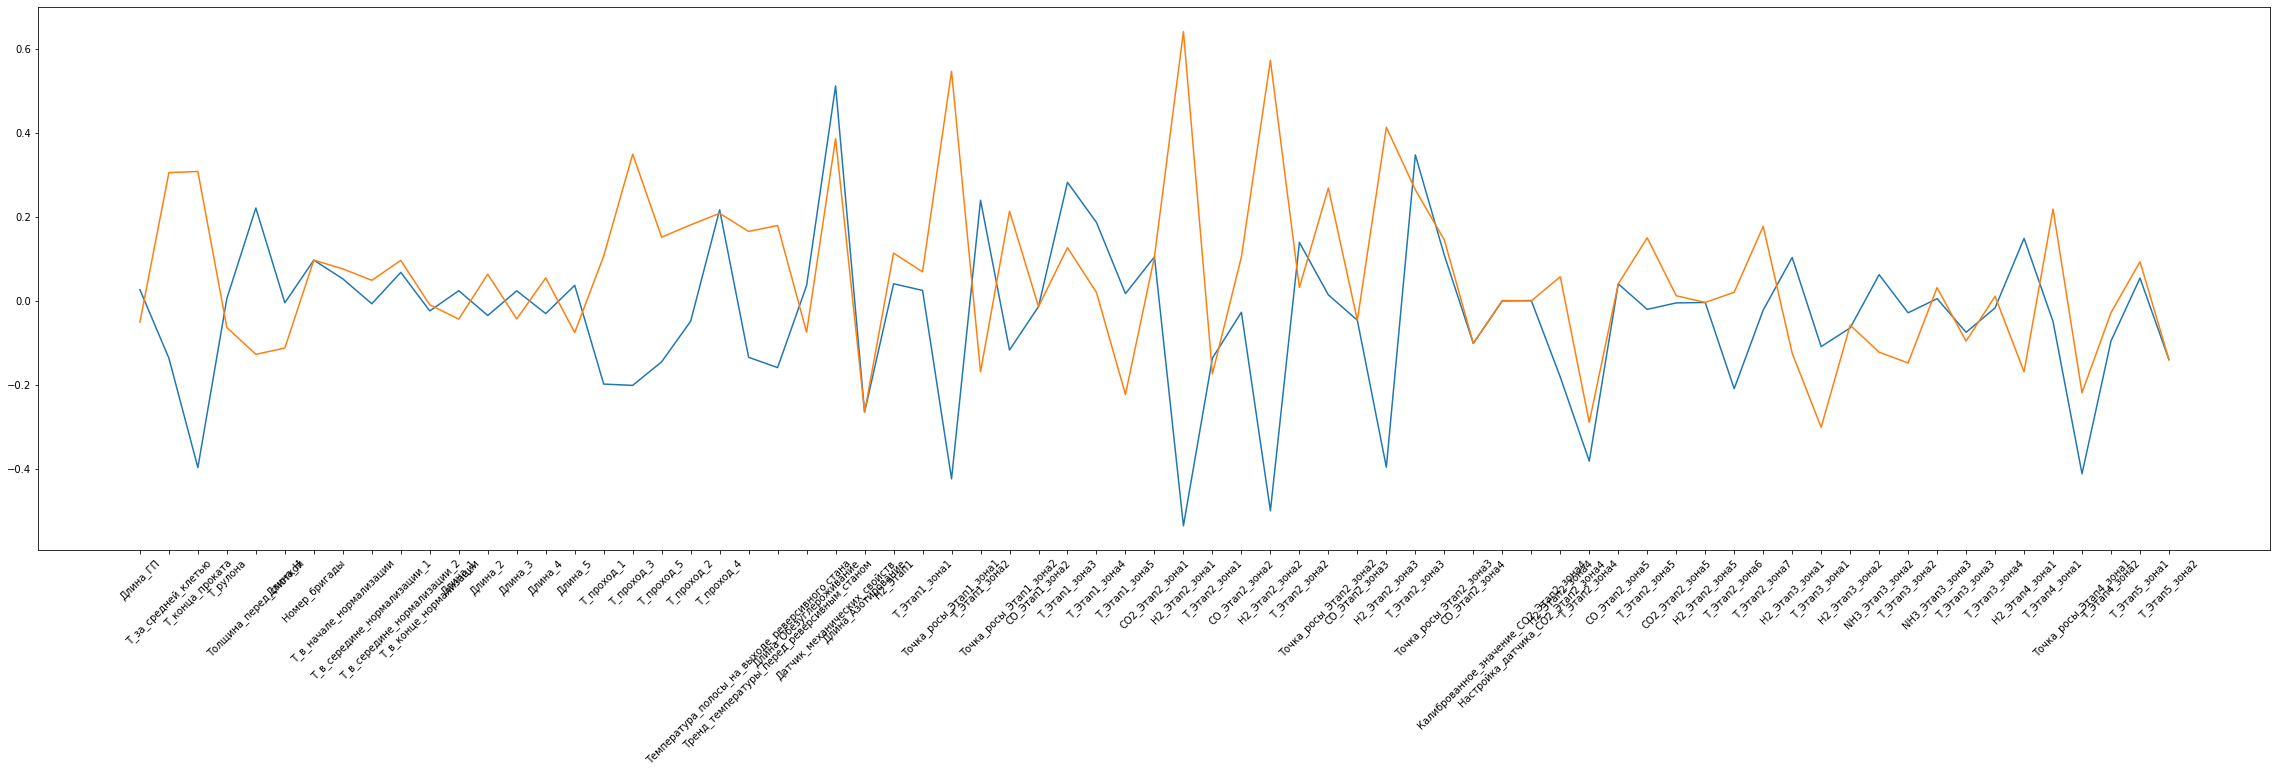

In [ ]:
df_num_quality=pd.concat([df_scaler [num_param] [df['Удельные_потери_кат'] ==0 ].median(), df_scaler [num_param] [df['Удельные_потери_кат'] ==1 ].median()], axis=1 )
print(df_num_quality)
fig, ax = plt.subplots( figsize=(40,10))
ax.plot(df_num_quality)
labels = ax.set_xticklabels(df_num_quality.index,  fontsize = 10, rotation = 45)
plt.show()

Видим, что медианные значения для части параметров зеркально отличаются на двух выборках. Посмотрим отличия для средних значений (чувствительнее к выбросам). 

                               0         1
N                      -0.344944  0.362136
Al                      0.388775 -0.408151
Si                      0.007462 -0.007834
Mn                      0.041448 -0.043513
Sn                     -0.054912  0.057648
...                          ...       ...
Т_Этап4_зона1          -0.086323  0.090626
Точка_росы_Этап4_зона1 -0.024045  0.025244
Т_Этап4_зона2          -0.034124  0.035825
Т_Этап5_зона1          -0.002885  0.003029
Т_Этап5_зона2          -0.019974  0.020970

[83 rows x 2 columns]


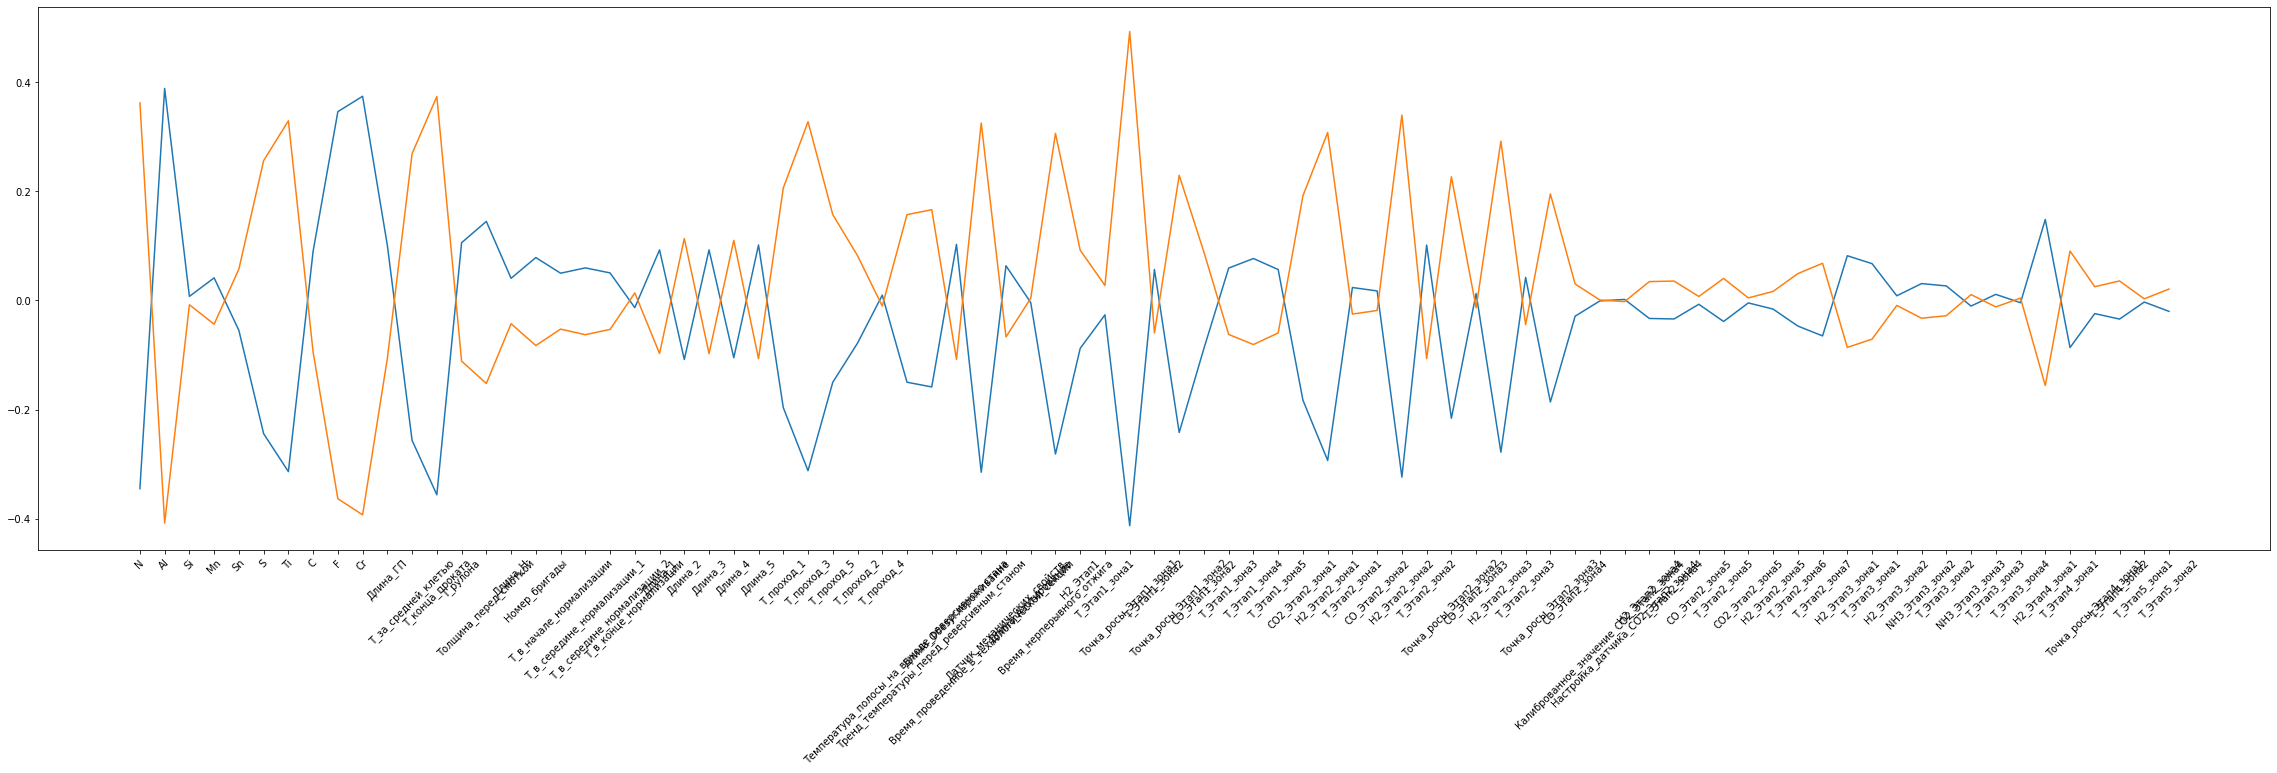

In [ ]:
df_quality=pd.concat([df_scaler [useful_param] [df['Удельные_потери_кат'] ==0 ].mean(), df_scaler [useful_param] [df['Удельные_потери_кат'] ==1 ].mean()], axis=1 )
print(df_quality)
fig, ax = plt.subplots( figsize=(40,10))
ax.plot(df_quality)
labels = ax.set_xticklabels(df_quality.index,  fontsize = 10, rotation = 45)
plt.show()

Видим что средние (м.о.) для двух выборок буквально зеркалят друг друга на всех параметрах. Что должно говорить о наличии обратной корреляции и что числовые признаки имеют влияние на получение качестенной продукции. Проверим эту гипотезу в следующем разделе

Важность вклада параметров может быть оценена колонкой diff в таблице ниже. Это разница средних. Именно так рекомендуется оценивать меру силы взаимосвязи пар переменных разных типов, как разницу м.о. параметра на обьектах, при условии что второй параметр принадлежит одной и другой категории:

Величина это не нормированная, так что в целях сравнения силы взаимосвязи между разными параметрами мы как раз используем мастабирование признаков.

In [ ]:
df_quality['diff']=abs(df_quality[0]-df_quality[1])
df_quality.sort_values('diff', ascending=False, inplace=True)#[df_quality['diff']>1]
df_quality

,0,1,diff
Точка_росы_Этап1_зона1,-0.412990,0.493032,0.906022
Al,0.388775,-0.408151,0.796926
Cr,0.374366,-0.393024,0.767389
T_конца_проката,-0.356240,0.373995,0.730234
F,0.346214,-0.363470,0.709684
...,...,...,...
T_Этап3_зона4,-0.004123,0.004328,0.008451
Длина_Азотирование,-0.003822,0.004012,0.007834
Т_Этап5_зона1,-0.002885,0.003029,0.005915
Настройка_датчика_CO2_Этап2_зона4,0.001932,-0.002028,0.003960


Таким образом мы наблюдаем связь признаков с целевой переменной. Посмотрим 
подробнее на каждый параметр и какое влияние он оказывает на целевой показатель. Оценим значимость корреляции критерием Стьюдента для нерперывных числовых параметров и криетрием Кси квадрат для категориальных.

# Data Visualisation and the dependence of parameters on the target function

У нас всего, по сути, будет проанализировано менее 120 параметров для более 12 тыс. примеров, то есть проверено менее 120 гипотез, из которых половина непрерывные показатели, оцениваемые криетрием Стьюдента. Поэтому мы не будем использовать поправки для множественной проверки гипотез здесь (Холма, Бенджамини-Хохберга).

## Химия плавки

Химия плавки


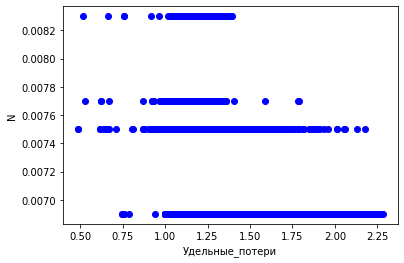

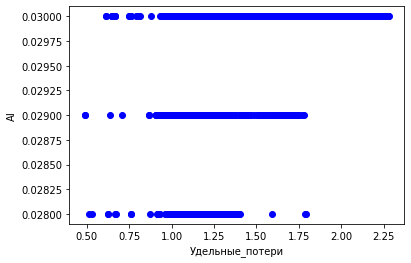

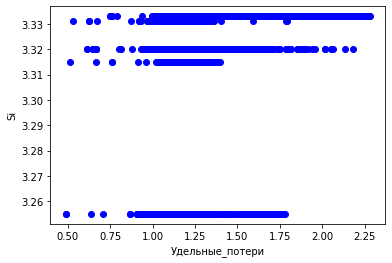

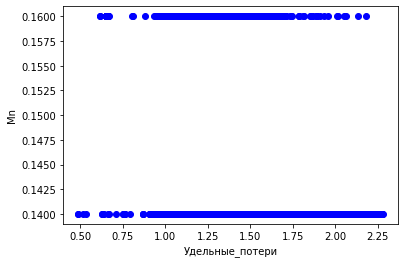

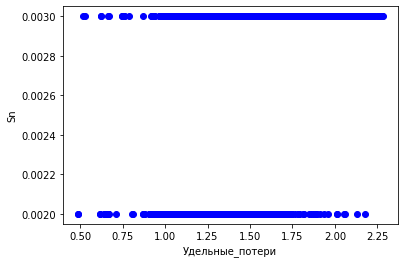

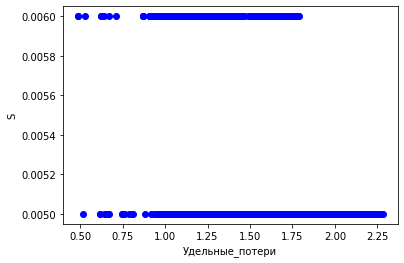

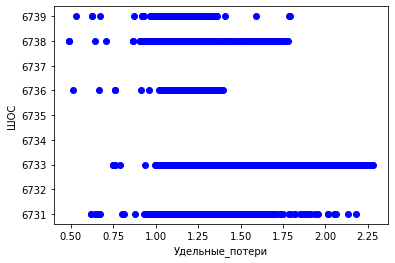

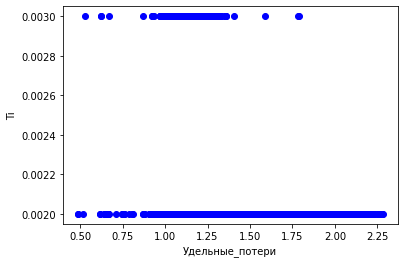

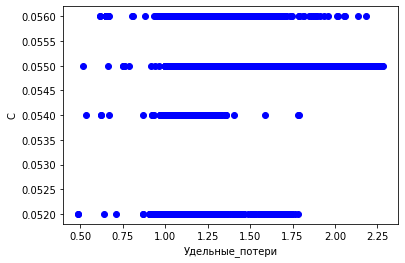

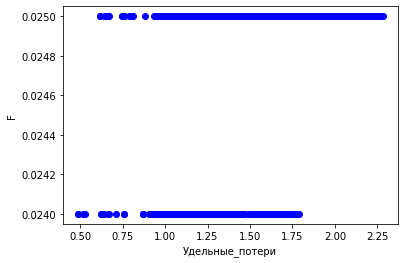

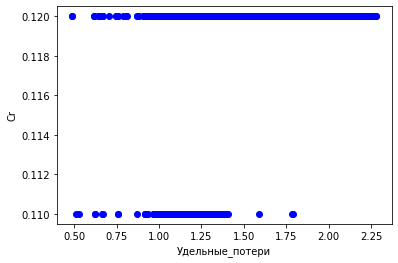

In [ ]:
print ('Химия плавки')
for i in stages['Химия плавки']:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

Все параметры на первом этапе категориальные, не равномерно распределенные классы. При анализе с несбалансированными классами можно бороться семплированием, стратификацией, бутстрепом (при проверке гипотез).


Этот этап - химический анализ рулона до обработки.
Соответственно необходимо проверить гипотезу 



### Гипотеза 1 - Влияет ли химический состав исходного материала на качество продукции? 

Взглянем как распределены существующие категории каждого параметра в количественном значении

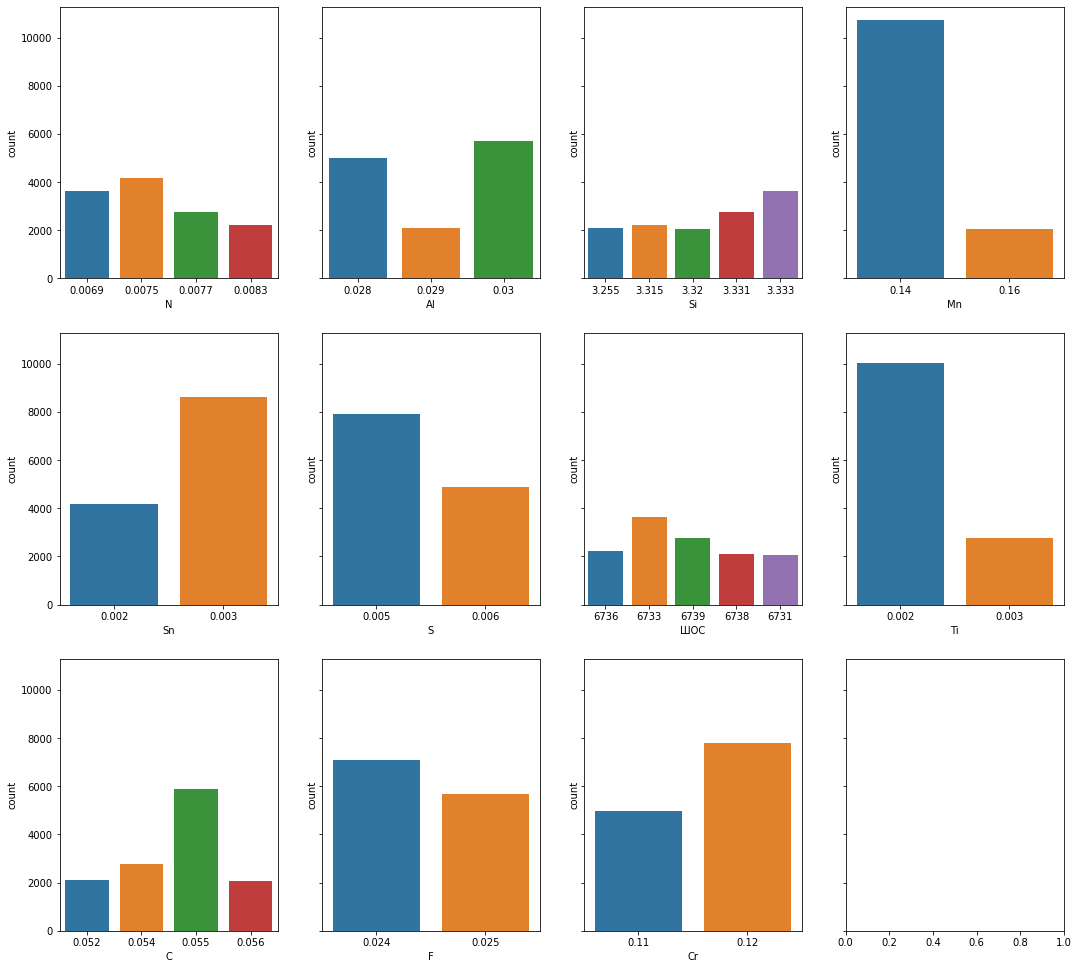

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(18, 17), sharey=True)
  
for i in range(len(stages['Химия плавки'])):
      sns.countplot(x=stages['Химия плавки'][i], data=df, ax=axes[int(i/4), int(i%4)])

Поcмотрим как отличаются показатели этого этапа для качественной и не качественной продукции в количественнм представлении:

Химия плавки


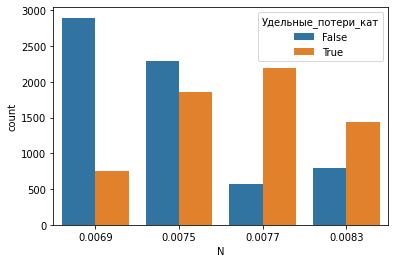

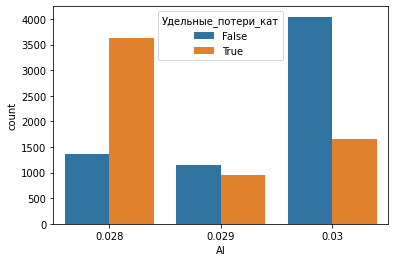

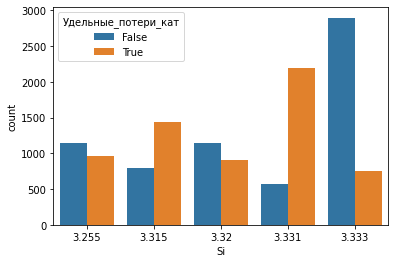

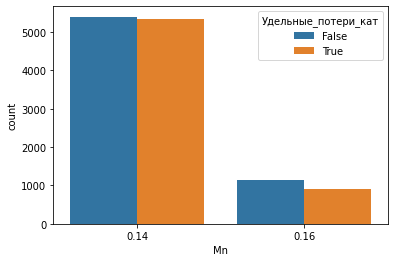

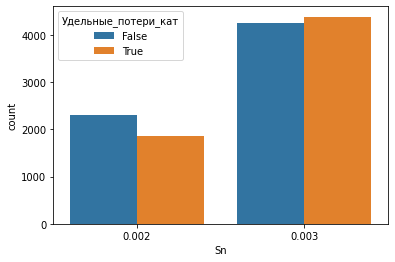

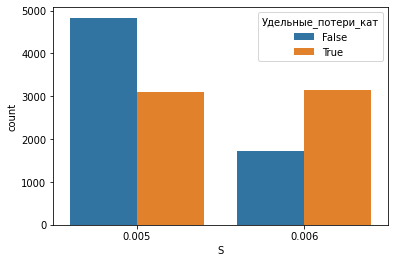

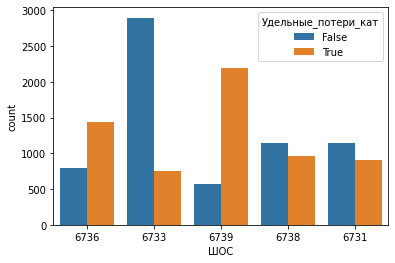

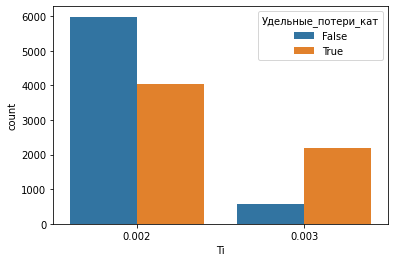

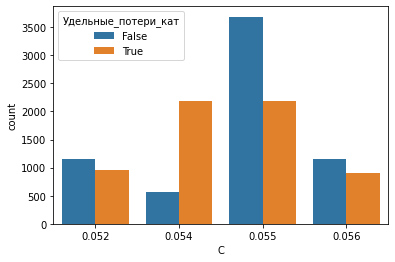

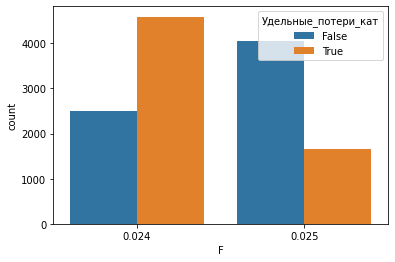

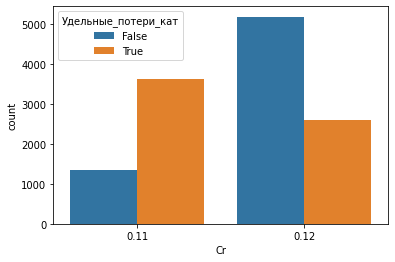

In [ ]:
print ('Химия плавки')
for i in stages['Химия плавки']:
  sns.countplot(x=i, hue="Удельные_потери_кат", data=df)
  plt.show()  

Визуально мы видим некоторые зависимости. Необходимо посчитать корреляцию.
Так как тут все параметры категориальыне как и целевой параметр, то будем считать корреляцию Крамера.

In [ ]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

Проверим односторонную гипотезу H0: p1=p2 
что параметр N  не влияет на качество продукции. 
Против двухсторонней альтернативы H1: p1 <> p2 
, что изменение параметра N влияет на изменение целевого показателя.

И сразу проверим значимость корреляции криерием Хи-квадрат. Условия применения этого критерия выполняются: всего не менее 40 примеров и в каждой категории не менее 5 примеров.


In [ ]:
for i in stages['Химия плавки'] :
  if i in unuseful_param:
      pass

  else:
    confusion_matrix = pd.crosstab(df [i], df['Удельные_потери_кат'])
    print( f"Корреляция Крамера для {i}: {cramers_v(confusion_matrix)}")
    chi2, p, dof, ex =stats.chi2_contingency(confusion_matrix)
    print(f"Проверка значимости корреляции Хи-криетрием chi2: {chi2} p-value: {p} \n\n")

Корреляция Крамера для N: 0.43683546290619935
Проверка значимости корреляции Хи-криетрием chi2: 2443.654804573507 p-value: 0.0 


Корреляция Крамера для Al: 0.4001514411398226
Проверка значимости корреляции Хи-криетрием chi2: 2049.9499829267997 p-value: 0.0 


Корреляция Крамера для Si: 0.4368401568637462
Проверка значимости корреляции Хи-криетрием chi2: 2444.7073345015497 p-value: 0.0 


Корреляция Крамера для Mn: 0.041320895530273155
Проверка значимости корреляции Хи-криетрием chi2: 22.83793390353641 p-value: 1.7625235891590232e-06 


Корреляция Крамера для Sn: 0.05539736949741071
Проверка значимости корреляции Хи-криетрием chi2: 40.250906665245665 p-value: 2.2335166362695482e-10 


Корреляция Крамера для S: 0.24989439178423223
Проверка значимости корреляции Хи-криетрием chi2: 799.6998514118334 p-value: 6.27074074456962e-176 


Корреляция Крамера для ШОС: 0.4368401568637462
Проверка значимости корреляции Хи-криетрием chi2: 2444.7073345015497 p-value: 0.0 


Корреляция Крамера для Ti:

Высоких значений p-value нет, все вычисленные корреляции значимы.

ЗДесь стоит отметить что разница в значениях (расстояния между значениями, например 0.11 и 0.12) настолкьо малы, что есть сомнение в возможности установить такие жесткие ограничения на используемый для плавки материал. 

Кроме того, можно проследить путь каждого сляба от плавки до конечной продукции и попытаться определить и оценить совметное последовательное влияние параметров (можно использовать регрессию)

## Горячий прокат

Горячий прокат


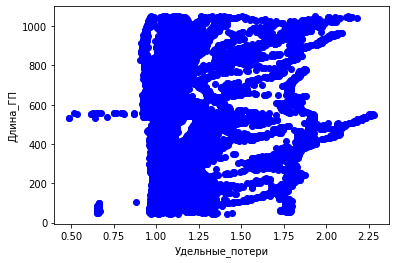

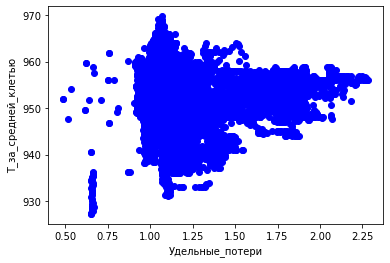

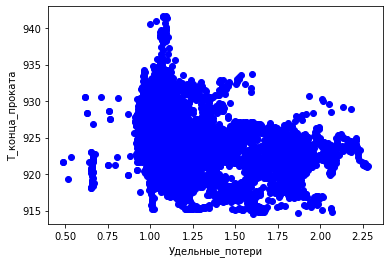

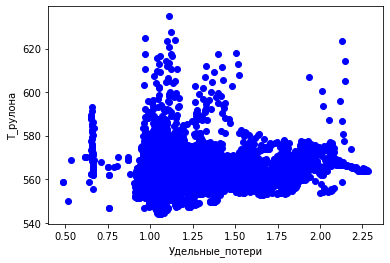

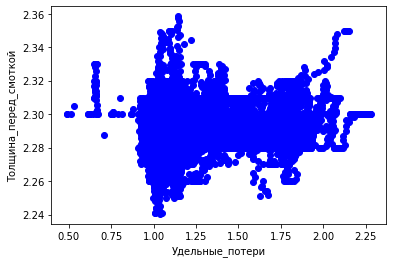

In [ ]:
print ('Горячий прокат')
for i in stages['Горячий прокат']:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

На некоторых графиках просматривается небольшая линейная зависимость, хотя это может быть особенностью  выборки.
На каждом графике на этапе горячего проката мы видим выделяющуюся небольшую полосу точек, характеризующих очень низкие удельные магнитные потери для определенных температур. Является ли это причиной или свойством выборки? Поcмотрим на распределение удельных потерь в целом:


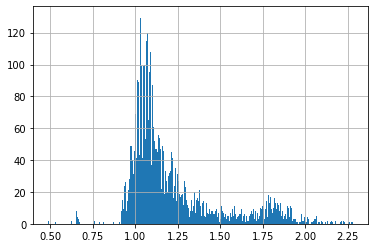

In [ ]:
df['Удельные_потери'].hist(bins=1000)

Действительно распределение скошенно влево, присутствует широкий правый  хвост и очень короткий левый, который на графиках просматривается как облако выборсов.

НА графиках вышое плохо визуализируется количественное распределение

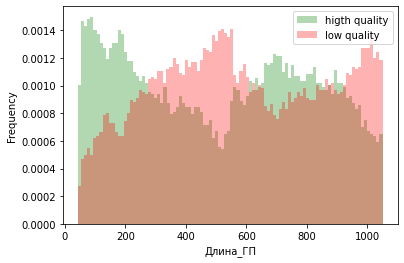

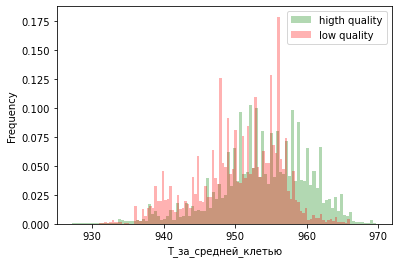

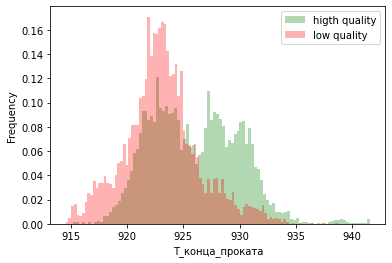

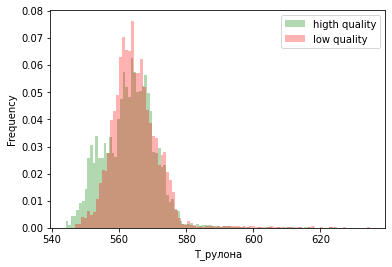

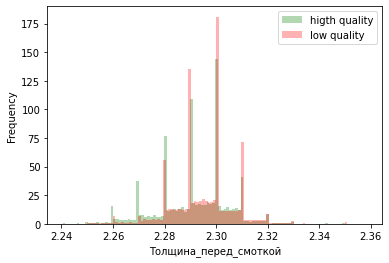

In [ ]:
for i in stages['Горячий прокат']:
  plt.hist(df[i][df['Удельные_потери_кат'] ==1], bins=100, color='g', density=True,  alpha=0.3, label='higth quality' ) #
  plt.hist(df[i][df['Удельные_потери_кат'] ==0], bins=100, color= 'r', density=True,  alpha=0.3, label='low quality' ) #
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

Здесь видно что есть некоторая не большая область температур, в которых зеленая область превышает красную, тоесть при которых качестенной продукции получается больше. Следовательно необходимо проверить гипотезу, что

### Гипотеза 2 - Верно ли что видимые на графиках области температур горячего проката, влияют на повышение количества выпускаемой качественной продукции?

С помощью критерия Стьюдента проверим гипотезу о развенстве средних двух выборок.

У нас всего, по сути, будет проанализировано менее 120 параметров для более 12 тысю примеров, тоесть проверено менее 120 гипотез, из которых половина непрерывные показатели, оцениваемые криетрием Стьюдента. Поэтому мы не будем использовать поправку Холма для множественной проверки гипотез.

Критерий Стьюдента:

𝐻0: средние значения температур на этом этапе для качественной и некачественной продукции равны.

𝐻0: не равны.

Для того, чтобы использовать двухвыборочный критерий Стьюдента, убедимся, что распределения в выборках существенно не отличаются от нормальных.

Populating the interactive namespace from numpy and matplotlib
Shapiro-Wilk normality test, W-statistic: 0.975046, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.971257, p-value: 0.000000


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


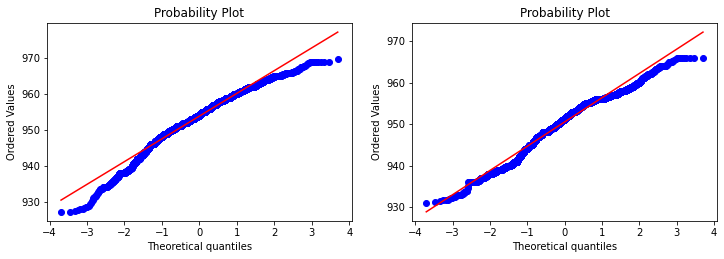

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk normality test, W-statistic: 0.978882, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.981830, p-value: 0.000000


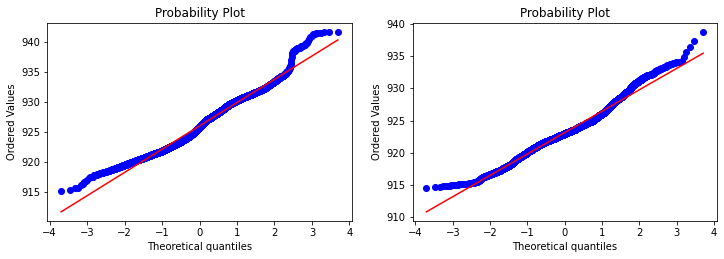

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk normality test, W-statistic: 0.958707, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.896904, p-value: 0.000000


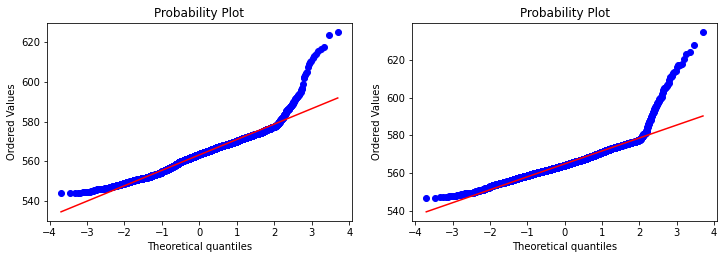

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk normality test, W-statistic: 0.977939, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.968608, p-value: 0.000000


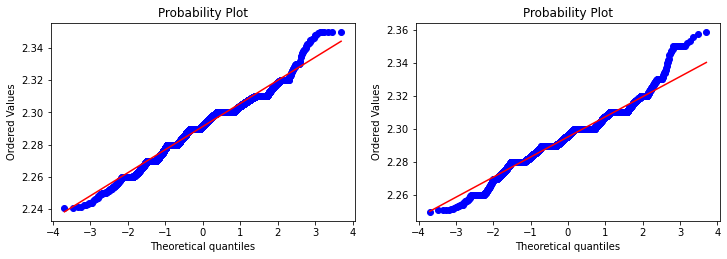

In [ ]:
%pylab inline
for i in stages['Горячий прокат'] [1:]:

  pylab.figure(figsize=(12,8))
  pylab.subplot(2,2,1)
  stats.probplot(df[i][df['Удельные_потери_кат'] ==1], dist="norm", plot=pylab)
  pylab.subplot(2,2,2)
  stats.probplot(df[i][df['Удельные_потери_кат'] ==0], dist="norm", plot=pylab)
  print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(df[i][df['Удельные_потери_кат'] ==1]))
  print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(df[i][df['Удельные_потери_кат'] ==0]))
  pylab.show()

Видим что QQ графики частично близки к нормальным, проверка Криетрием Шапиро-Уилка, показала что температуры для обоих выборок для каждой из температур распредлены нормально.

In [ ]:
for i in stages['Горячий прокат'] [1:]:

  print(f" \n\n For {i}   {scipy.stats.ttest_ind(df[i][df['Удельные_потери_кат'] ==1] , df[i][df['Удельные_потери_кат'] ==0], equal_var = False)}")
  cm = CompareMeans(DescrStatsW(df[i][df['Удельные_потери_кат'] ==1]), DescrStatsW(df[i][df['Удельные_потери_кат'] ==0]))
  print(f" For {i} 95%% confidence interval : [%f, %f]" % cm.tconfint_diff(usevar='unequal'))

 

 For T_за_средней_клетью   Ttest_indResult(statistic=30.745280585506272, pvalue=3.2609105388515966e-200)
 For T_за_средней_клетью 95% confidence interval : [3.148913, 3.577770]
 

 For T_конца_проката   Ttest_indResult(statistic=44.171954105015544, pvalue=0.0)
 For T_конца_проката 95% confidence interval : [2.729266, 2.982740]
 

 For T_рулона   Ttest_indResult(statistic=-12.317657986735009, pvalue=1.153749354806176e-34)
 For T_рулона 95% confidence interval : [-1.919950, -1.392783]
 

 For Толщина_перед_смоткой   Ttest_indResult(statistic=-16.91711370855228, pvalue=1.7682250743374515e-63)
 For Толщина_перед_смоткой 95% confidence interval : [-0.004506, -0.003570]


Все р-value меньше 0.05, так что с вероятностью меньше 5% мы можем ошибиться, отвергрнув нулевую гипотезу о равенстве средних. С вероятностью р можно получить разные средние температуры на выборке из качестенной и некачественной продукции в этом эксперименте, а в реальности они не отличаются.

Также конфициенциальные интервалы не включают ноль, значит разница на этих параметрах есть.

### Гипотеза 2.1 Верно ли что средний размер рулона отличается для качественной и не качестенной продукции?

In [ ]:
for i in stages['Горячий прокат'] [:1]:
  print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(df[i][df['Удельные_потери_кат'] ==1]))
  print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(df[i][df['Удельные_потери_кат'] ==0]))
  print(f" \n\n For {i}   {scipy.stats.ttest_ind(  df[i][(df['Удельные_потери_кат'] ==1) ] , df[i][(df['Удельные_потери_кат'] ==0)  ], equal_var = False) }")
  cm = CompareMeans(DescrStatsW(df[i][(df['Удельные_потери_кат'] ==1)  ]), DescrStatsW( df[i][(df['Удельные_потери_кат'] ==0)]) )
  print(f" For {i} 95%% confidence interval : [%f, %f]" % cm.tconfint_diff(usevar='unequal'))

Shapiro-Wilk normality test, W-statistic: 0.940954, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.961643, p-value: 0.000000
 

 For Длина_ГП   Ttest_indResult(statistic=-11.749894016885014, pvalue=1.034620099061497e-31)
 For Длина_ГП 95% confidence interval : [-69.620778, -49.713140]


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Да, средние отличаются, но это не говорит о наличии причинно-следственной связи. 

Давайте посмотрим, останется ли предсказательная сила у длины рулона, если мы учтем воздействие всех остальных параметров (возможно случайно совпало, что на рулонах этой длины в последующих и предыдущих этапах были  максимально эффективные параметры на всех этапах).

Для этого построим линейную регрессию.

In [ ]:
df['Длина_ГП']

Вопрос к технологу: (Не нашла в интернете) На практике рулоны выпускаются одинаковой толщины? Факт что более крупные детали остывают и нагреваются медленнее, значит размер может влиять на температуру рулона. Но влияет ли только толщина рулона или другие два измерения тоже оказываются влияние? Интересует мнение специалиста-практика.



Если окажется что на скорость изменения температуры внутри рулона влияет не только толщина, но и другие геометрические размеры, тогда второй вопрос:
Может ли нарезка на рулоны осуществляться последим этапом?
Что проще и дешевле - регулировать температуру или нарезку рулонов?

## Нормализация

Нормализаци


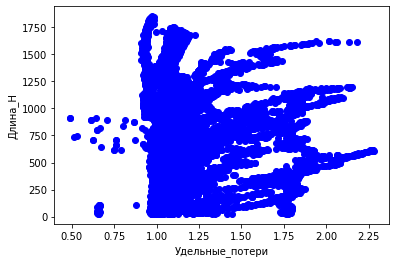

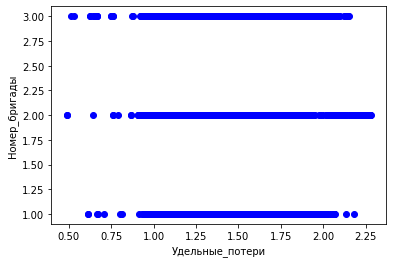

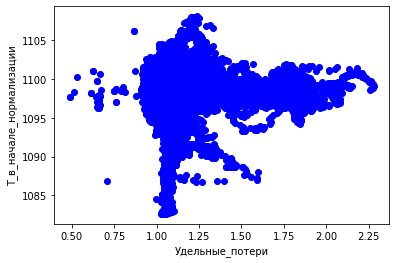

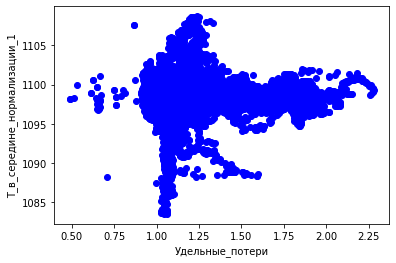

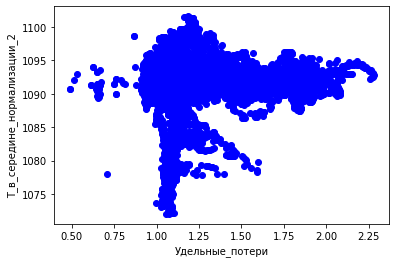

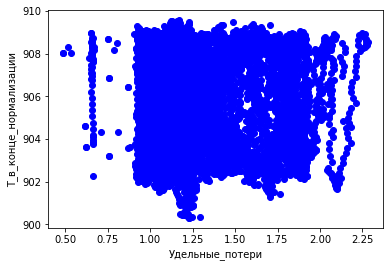

In [ ]:
print ('Нормализация')
for i in stages['Нормализация']:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

На графиках температур наблюдаем схожую между собой нелинейную зависимость и наличие четко отделенного облака точек с особо низким показетелем удельных магнитных потерь.

НА графиках вышое плохо визуализируется количественное распределение

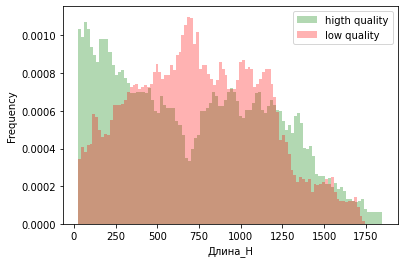

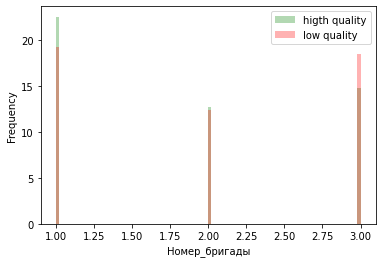

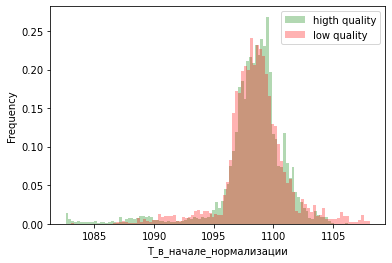

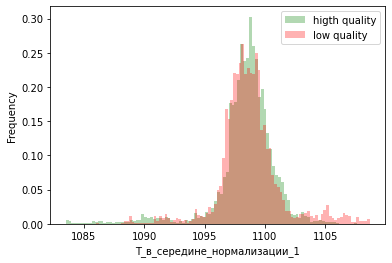

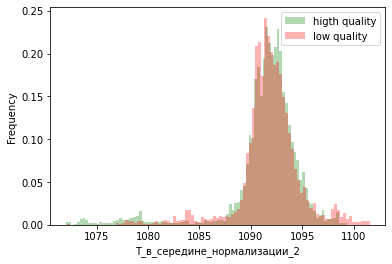

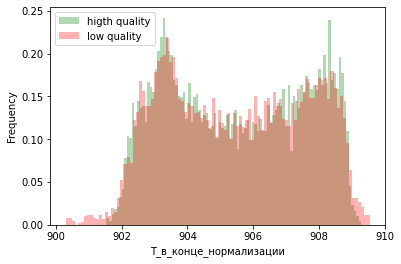

In [ ]:
for i in stages['Нормализация']:
  plt.hist(df[i][df['Удельные_потери_кат'] ==1], bins=100, color='g', density=True,  alpha=0.3, label='higth quality' ) #
  plt.hist(df[i][df['Удельные_потери_кат'] ==0], bins=100, color= 'r', density=True,  alpha=0.3, label='low quality' ) #
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

Здесь видно что есть некоторая не большая область температур, в которых зеленая область превышает красную, тоесть при которых качестенной продукции получается больше. Кроме того видим различия в зависимости от длины. 

 Следовательно необходимо проверить гипотезы, что 

### Гипотеза 3.1 - Верно ли что при более низких температурах в начале и середине нормализации получается больше качественной продукции?

С помощью критерия Стьюдента проверим гипотезу о развенстве средних двух выборок.

Критерий Стьюдента:

𝐻0: средние значения температур на этом этапе для качественной и некачественной продукции равны.

𝐻0: не одинаковы.


Для того, чтобы использовать двухвыборочный критерий Стьюдента, убедимся, что распределения в выборках существенно не отличаются от нормальных.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk normality test, W-statistic: 0.802756, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.923911, p-value: 0.000000


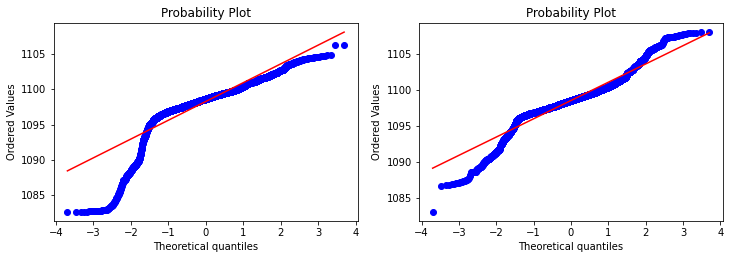

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk normality test, W-statistic: 0.821197, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.904239, p-value: 0.000000


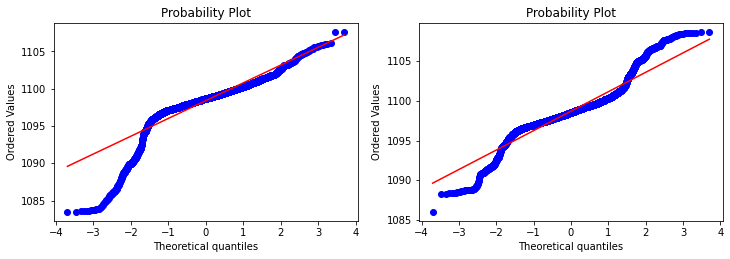

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk normality test, W-statistic: 0.741396, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.886485, p-value: 0.000000


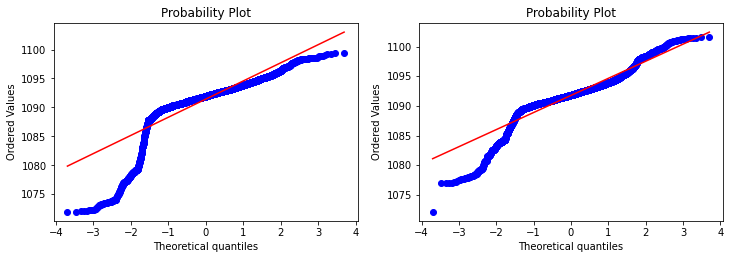

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Shapiro-Wilk normality test, W-statistic: 0.939125, p-value: 0.000000
Shapiro-Wilk normality test, W-statistic: 0.956166, p-value: 0.000000


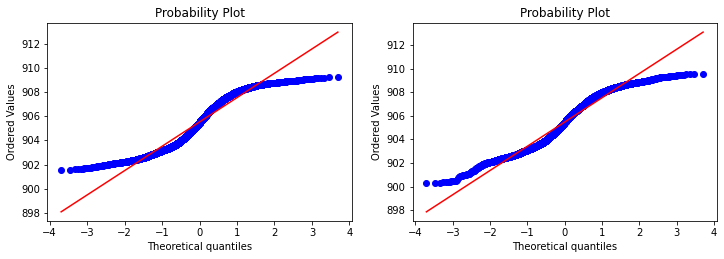

In [ ]:
%pylab inline
for i in stages['Нормализация'] [2:]:

  pylab.figure(figsize=(12,8))
  pylab.subplot(2,2,1)
  stats.probplot(df[i][df['Удельные_потери_кат'] ==1], dist="norm", plot=pylab)
  pylab.subplot(2,2,2)
  stats.probplot(df[i][df['Удельные_потери_кат'] ==0], dist="norm", plot=pylab)
  print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(df[i][df['Удельные_потери_кат'] ==1]))
  print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(df[i][df['Удельные_потери_кат'] ==0]))
  pylab.show()

Видим что QQ графики частично близки к нормальным, проверка Криетрием Шапиро-Уилка, показала что температуры для обоих выборок для каждой из температур  распредлены нормально.

In [ ]:
for i in stages['Нормализация'] [2:]:

  print(f" \n\n For {i}   {scipy.stats.ttest_ind(df[i][df['Удельные_потери_кат'] ==1] , df[i][df['Удельные_потери_кат'] ==0], equal_var = False)}")
  cm = CompareMeans(DescrStatsW(df[i][df['Удельные_потери_кат'] ==1]), DescrStatsW(df[i][df['Удельные_потери_кат'] ==0]))
  print(f" For {i} 95%% confidence interval : [%f, %f]" % cm.tconfint_diff(usevar='unequal'))

 

 For T_в_начале_нормализации   Ttest_indResult(statistic=-5.784737644263881, pvalue=7.437248319253339e-09)
 For T_в_начале_нормализации 95% confidence interval : [-0.386628, -0.190925]
 

 For T_в_середине_нормализации_1   Ttest_indResult(statistic=-6.933702092523347, pvalue=4.297606523335403e-12)
 For T_в_середине_нормализации_1 95% confidence interval : [-0.409762, -0.229144]
 

 For T_в_середине_нормализации_2   Ttest_indResult(statistic=-5.836677019728793, pvalue=5.46059117935418e-09)
 For T_в_середине_нормализации_2 95% confidence interval : [-0.464229, -0.230811]
 

 For T_в_конце_нормализации   Ttest_indResult(statistic=1.5250072515946531, pvalue=0.1272820539465299)
 For T_в_конце_нормализации 95% confidence interval : [-0.016082, 0.128802]


Видим, что все р-value, кроме последнего, меньше 0.05, так что с вероятностью меньше 5% мы можем ошибиться, отвергрнув нулевую гипотезу о равенстве средних. С вероятностью р можно получить разные средние температуры на выборке из качестенной и некачественной продукции в этом эксперименте, а в реальности они не отличаются.


Также конфициенциальные интервалы не включают ноль, кроме последнего, значит разница на этих параметрах есть.

### Гипотеза 3.2 Верно ли, что размер рулона влияет на его качество, а точнее, что рулоны больших размеров следует остужать или нагревать более интенсивно, чем меньших размеров

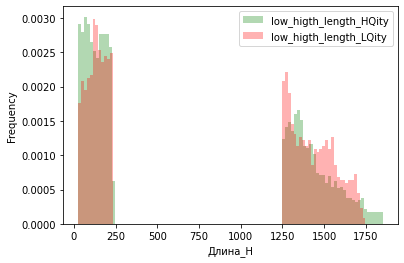

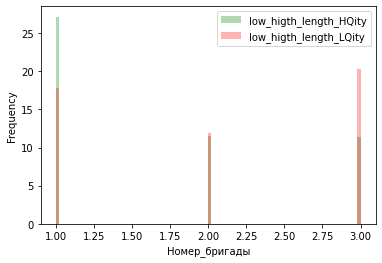

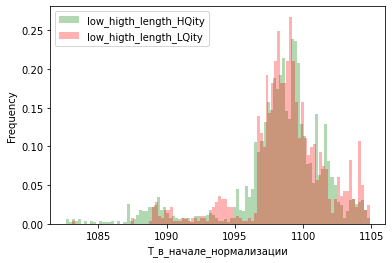

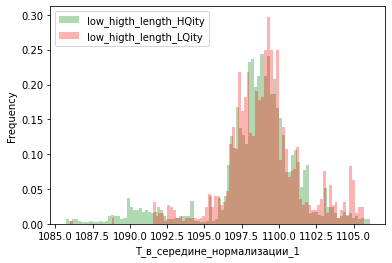

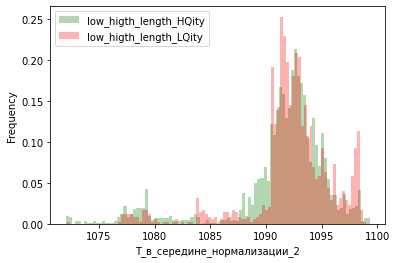

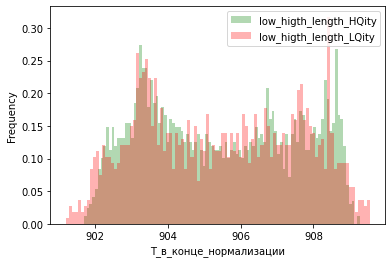

In [ ]:
for i in stages['Нормализация']:
  #plt.hist(df[i][ (df['Удельные_потери_кат'] ==1) & (df['Длина_Н'] >250) & (df['Длина_Н'] <1250) ], bins=100, color='b', density=True,  alpha=0.3, label='midium_length_HQity' ) #
  plt.hist(df[i][ (df['Удельные_потери_кат'] ==1) & ((df['Длина_Н'] <230) | (df['Длина_Н'] >1250)) ], bins=100, color= 'g', density=True,  alpha=0.3, label='low_higth_length_HQity' ) #
  #plt.hist(df[i][ (df['Удельные_потери_кат'] ==0) & (df['Длина_Н'] >250) & (df['Длина_Н'] <1350) ], bins=100, color='r', density=True,  alpha=0.3, label='midium_length_LQity' ) #
  plt.hist(df[i][ (df['Удельные_потери_кат'] ==0) & ((df['Длина_Н'] <230) | (df['Длина_Н'] >1250)) ], bins=100, color= 'r', density=True,  alpha=0.3, label='low_higth_length_LQity' ) #
  
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

## Холодный прокат

Холодный прокат


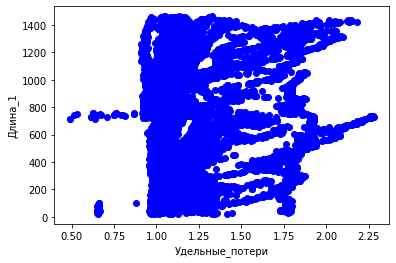

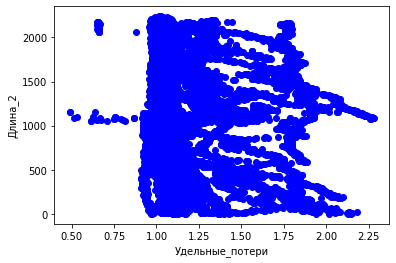

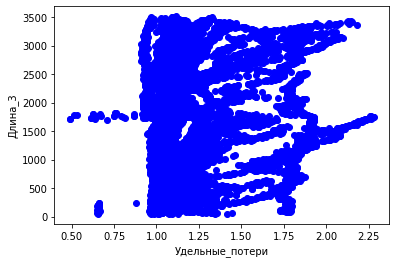

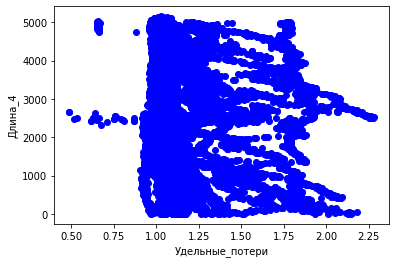

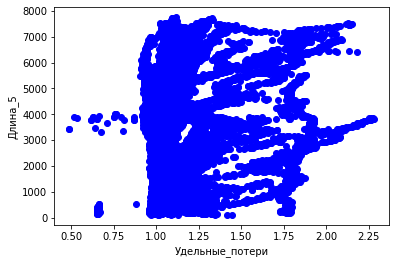

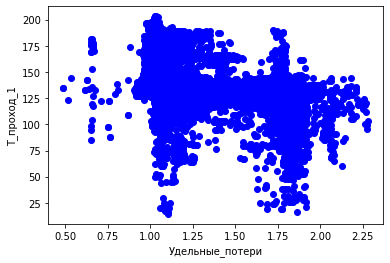

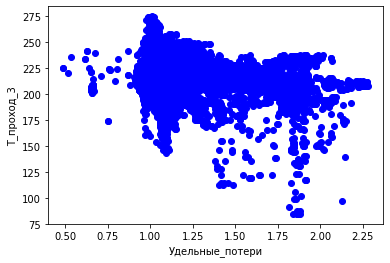

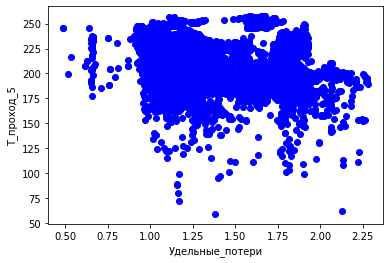

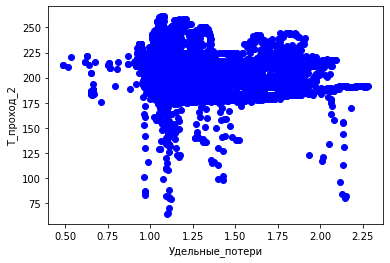

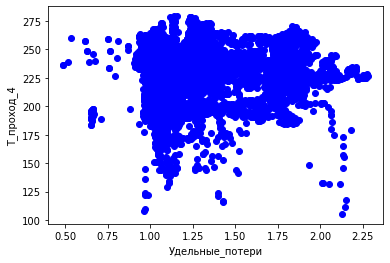

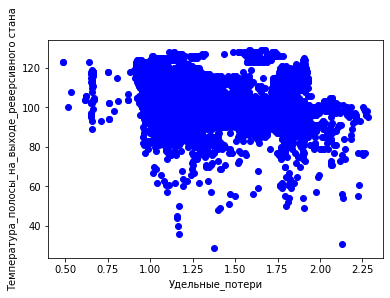

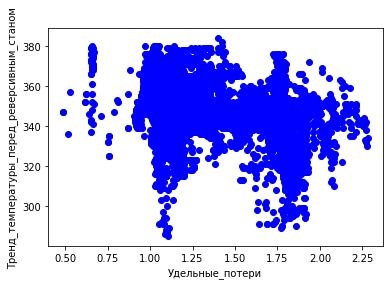

In [ ]:
print ('Холодный прокат')
for i in stages['Холодный прокат']:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

На графиках температур и длины наблюдаем  наличие четко отделенного облака точек с особо низким показетелем удельных магнитных потерь. При этом облако особо низких удельных потерь формируется только при определенных температурах.

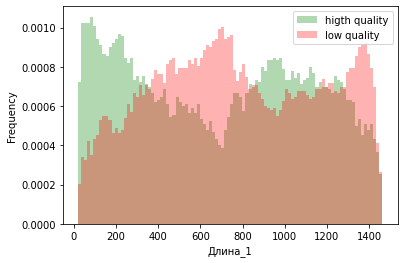

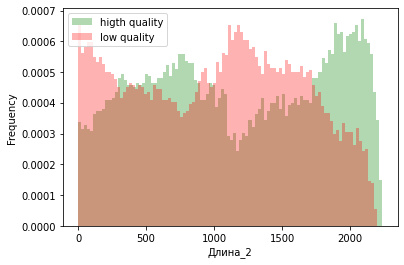

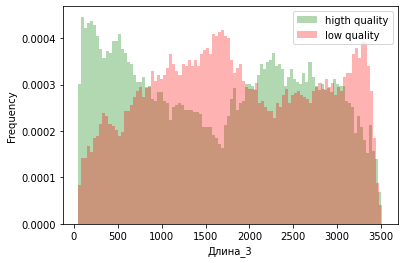

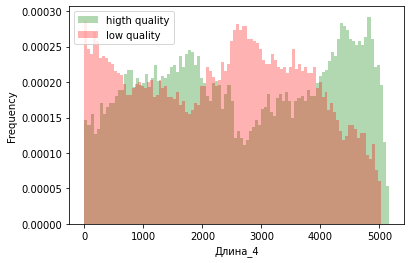

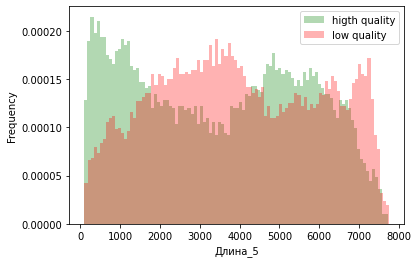

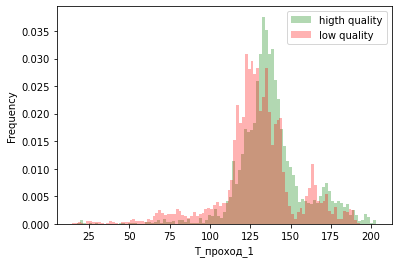

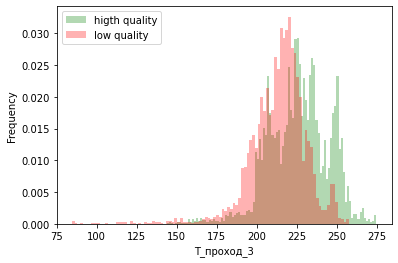

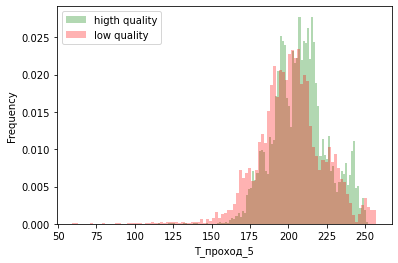

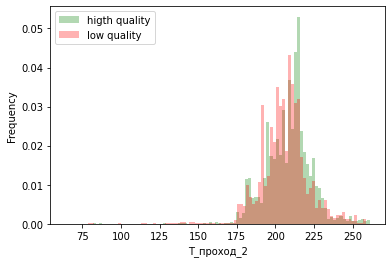

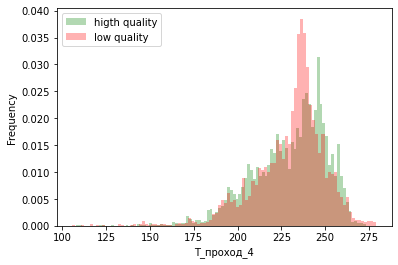

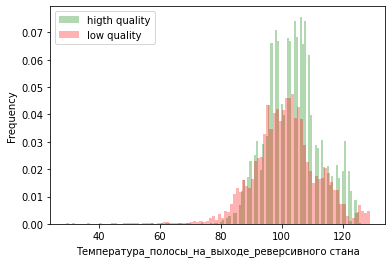

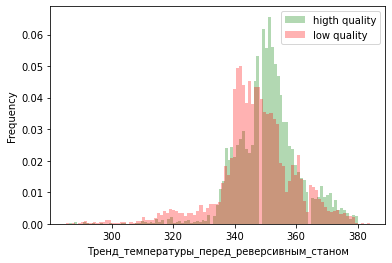

In [ ]:
for i in stages['Холодный прокат']:
  plt.hist(df[i][df['Удельные_потери_кат'] ==1], bins=100, color='g', density=True,  alpha=0.3, label='higth quality' ) #
  plt.hist(df[i][df['Удельные_потери_кат'] ==0], bins=100, color= 'r', density=True,  alpha=0.3, label='low quality' ) #
  plt.xlabel(i)
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

Действительно, на графиках заметно некоторе смещение для выборки высокого и низкого качества. Необходимо проверить эту гипотезу
### Гипотеза 4 - Верно ли что лучше (быстрее) остывшие куски к этапу холодного проката дают больше качественной продукции?

In [ ]:
df[i].nunique()

12757

## Обезуглероживание

Обезуглероживание


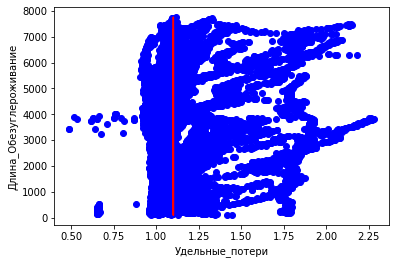

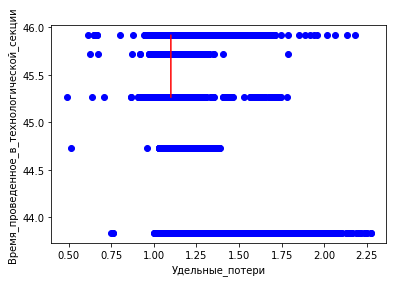

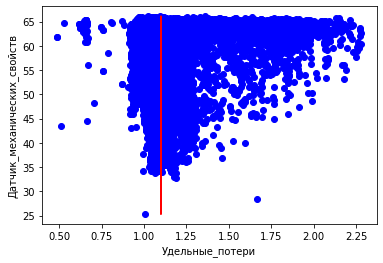

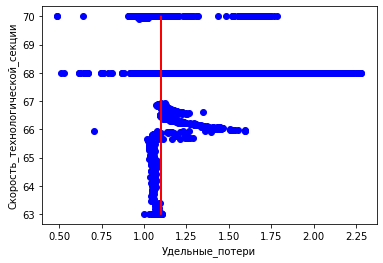

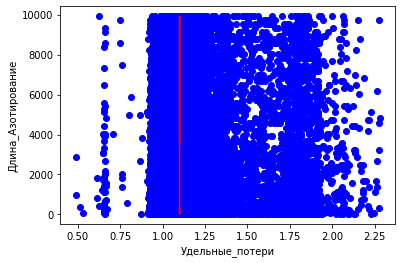

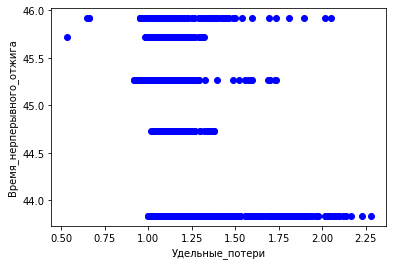

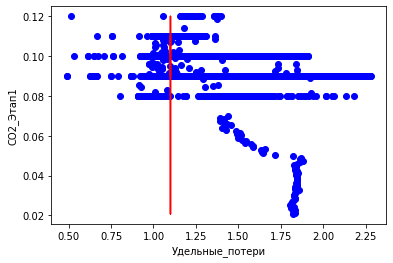

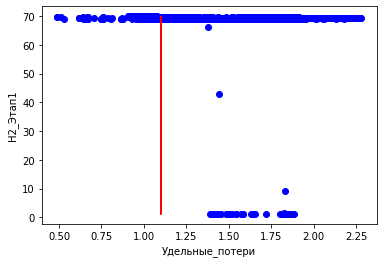

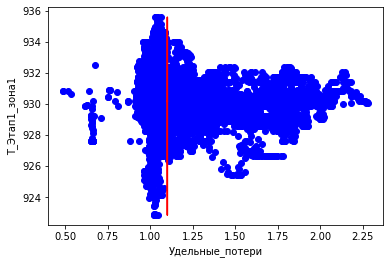

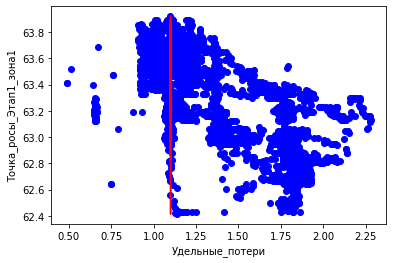

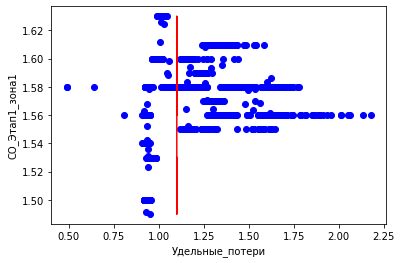

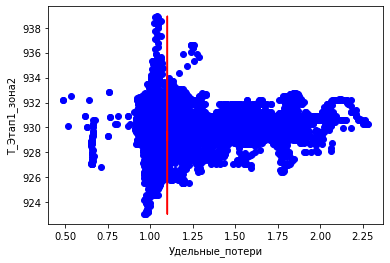

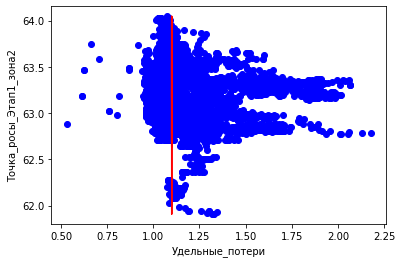

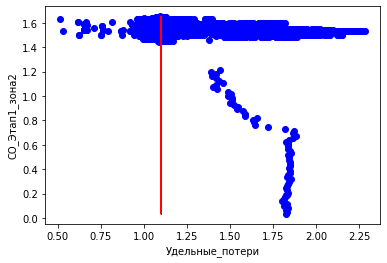

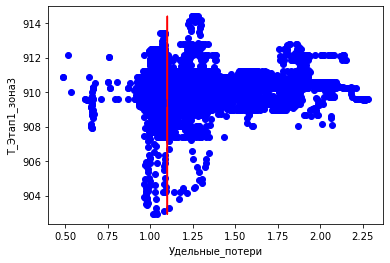

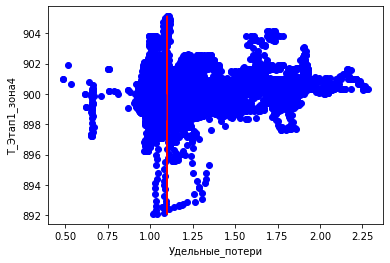

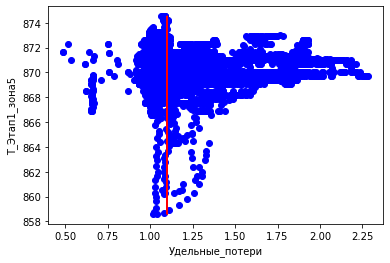

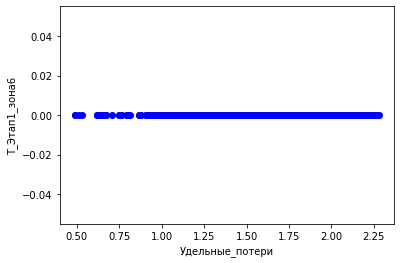

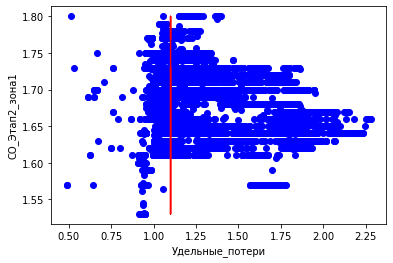

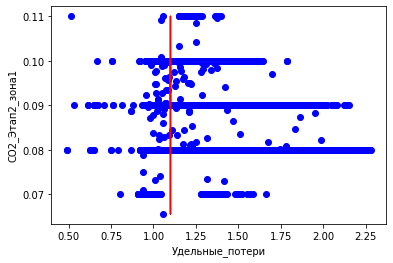

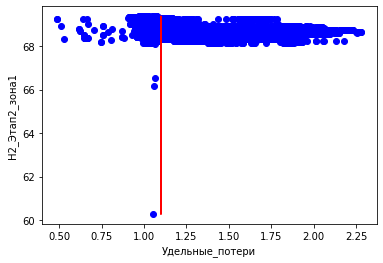

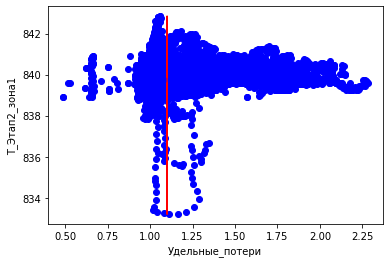

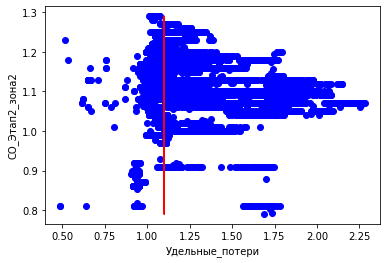

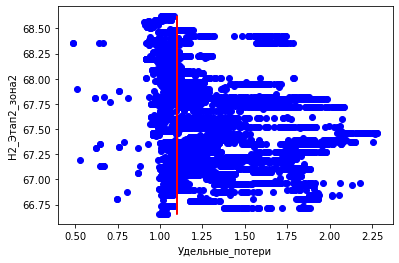

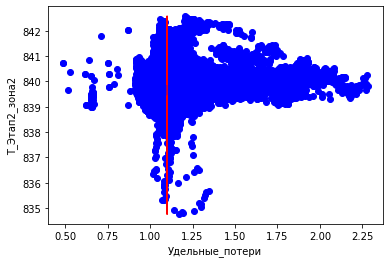

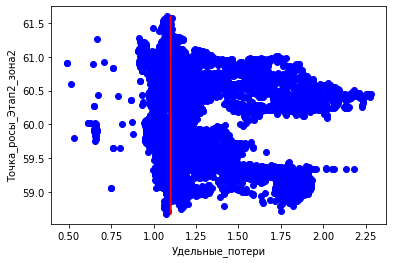

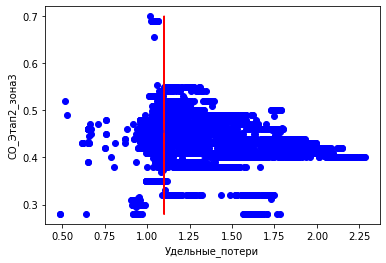

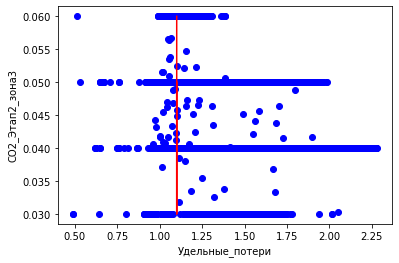

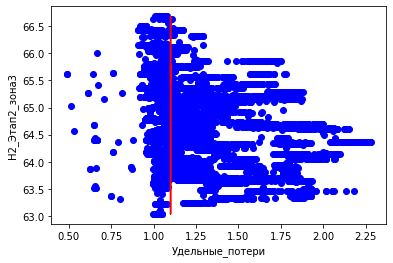

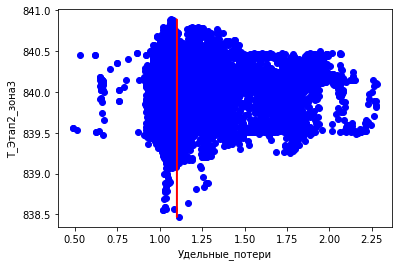

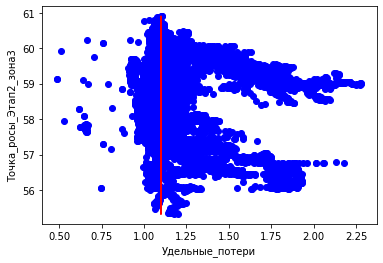

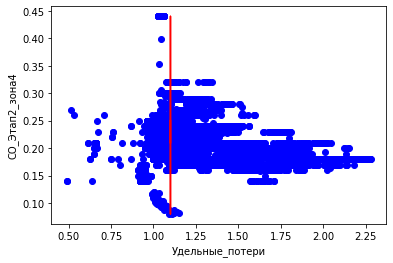

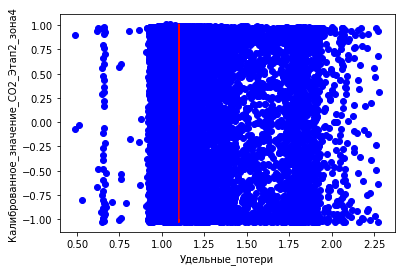

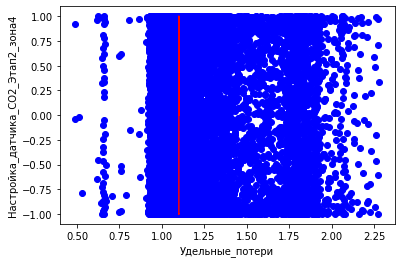

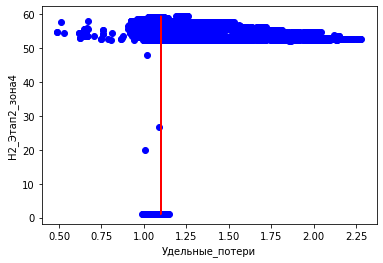

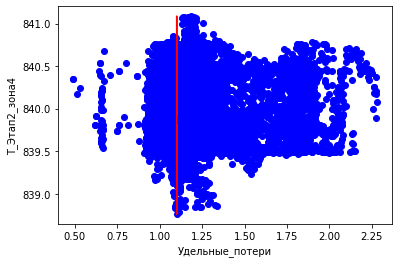

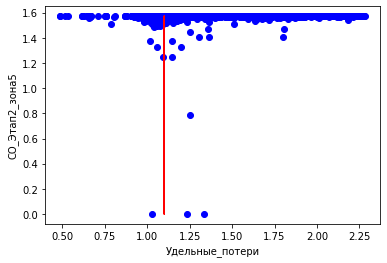

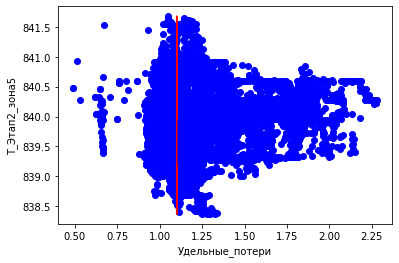

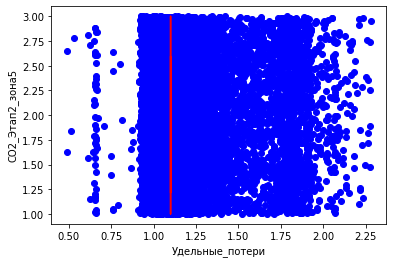

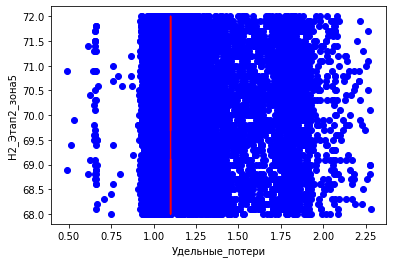

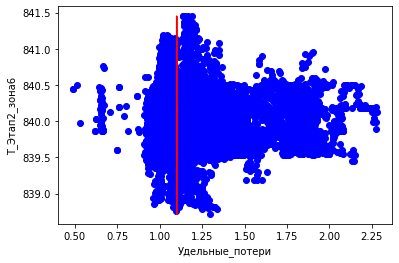

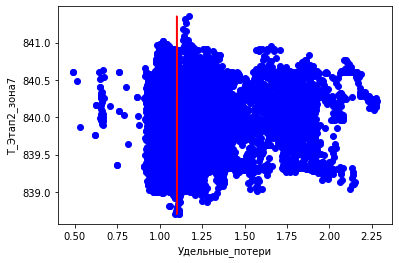

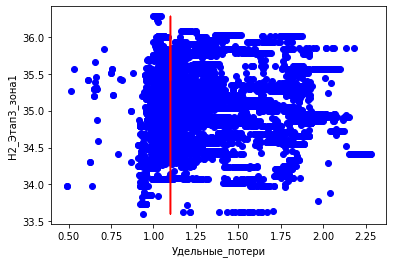

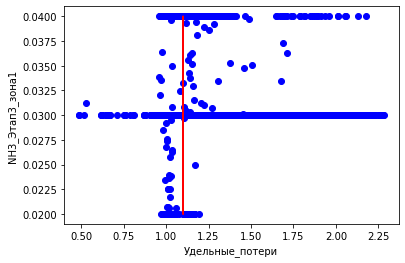

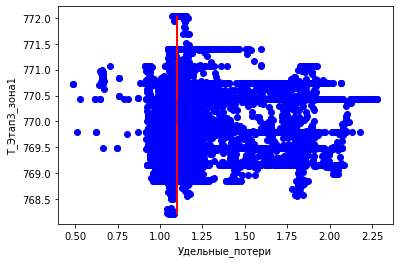

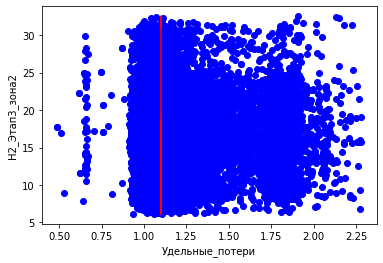

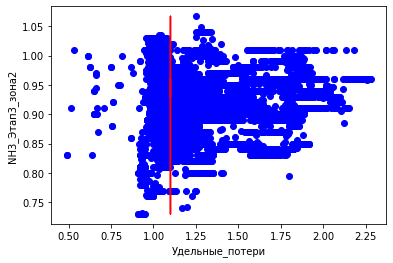

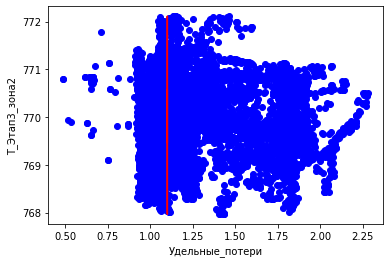

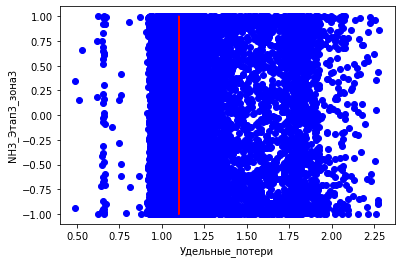

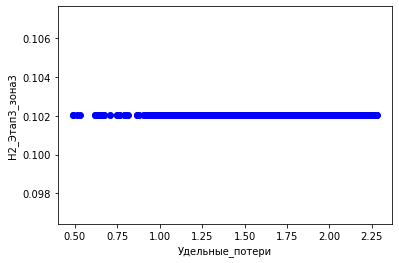

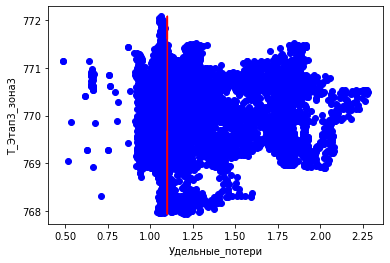

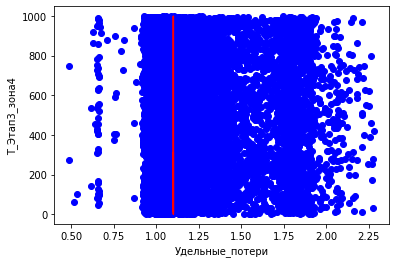

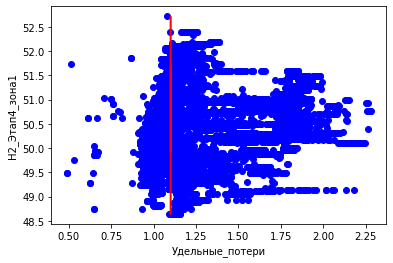

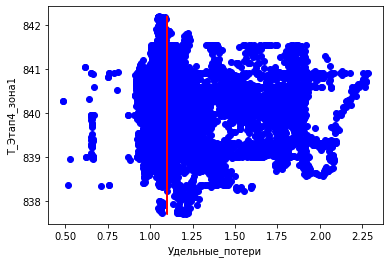

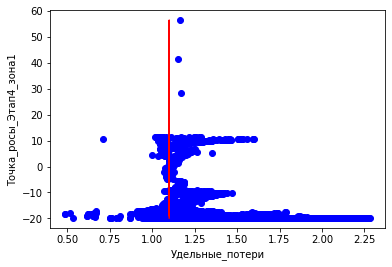

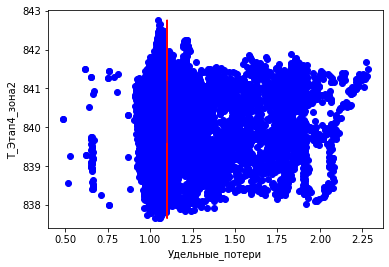

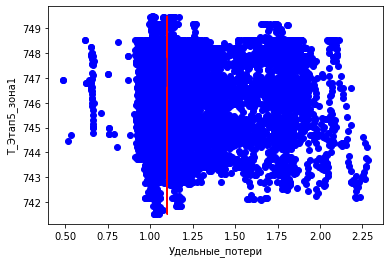

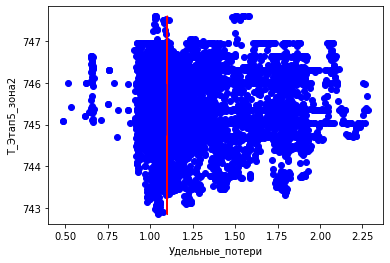

In [ ]:
print ('Обезуглероживание')
for i in stages['Обезуглероживание']:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.plot([1.1]*len(df[i]), df[i].values, 'r')
  #plt.plot( df['Удельные_потери'].values, [67]*len(df[i]), 'r')
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

Здесь мы видим, что многие параметры по сути необходимо отнести к категориальным, такие как: время проведенное в технологической секции и время непрерывного отжига, а также показатели воздействующих веществ, если удалить выбросы.


Вопрос к технологу: в каких величинах измерены все химические параметры и параметры с датчиков (кроме времении и температуры)?
Почему параметры химических веществ на этапе Обезуглероживание появляются исключительно  в нексольких  дискретных дозировках?

### Prepare numerical and categorical features list

 Made categorical features list

In [ ]:
stages['Обезуглероживание']

cat_param= ['Время_проведенное_в_технологической_секции', 'Скорость_технологической_секции','Время_нерперывного_отжига','CO2_Этап1',
 'H2_Этап1', 'CO_Этап1_зона1', 'CO_Этап2_зона1', 'CO2_Этап2_зона3', 'NH3_Этап3_зона1', 'ШОС', 'CO_Этап2_зона3']



In [ ]:
num_param= [ i for i in num_param if i not in cat_param ]

cat_param[0]  in num_param

False

На графиках плохо видны значения временных показателей. Округлим их для лучшей визуализации

In [ ]:
print(df['Время_проведенное_в_технологической_секции'].value_counts())
df['Время_проведенное_в_технологической_секции']= df['Время_проведенное_в_технологической_секции'].apply(lambda x: round(x,2))
df['Время_проведенное_в_технологической_секции'].value_counts()

43.833333    1632
45.716667    1331
44.733333    1057
45.266667     979
45.916667     926
Name: Время_проведенное_в_технологической_секции, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


43.83    1632
45.72    1331
44.73    1057
45.27     979
45.92     926
Name: Время_проведенное_в_технологической_секции, dtype: int64

In [ ]:
print(df['Время_нерперывного_отжига'].value_counts())
df['Время_нерперывного_отжига']= df['Время_нерперывного_отжига'].apply(lambda x: round(x,2))
df['Время_нерперывного_отжига'].value_counts()

43.833333    355
45.716667    267
45.266667    224
44.733333    220
45.916667    187
Name: Время_нерперывного_отжига, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


43.83    355
45.72    267
45.27    224
44.73    220
45.92    187
Name: Время_нерперывного_отжига, dtype: int64

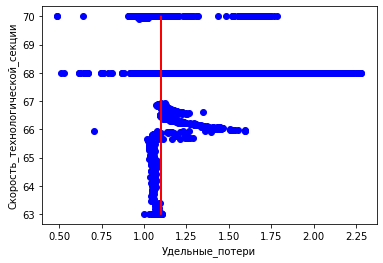

In [ ]:
plt.plot(df['Удельные_потери'].values, df['Скорость_технологической_секции'].values, 'bo')
plt.plot([1.1]*len(df['Скорость_технологической_секции']), df['Скорость_технологической_секции'].values, 'r')
plt.xlabel('Удельные_потери')
plt.ylabel('Скорость_технологической_секции')
plt.show()

In [ ]:
df['Скорость_технологической_секции_кат']=df['Скорость_технологической_секции'].apply(lambda x:  '63-65.5' if x < 65.5 else( '65.5-67' if x <67 else( '70' if x > 69.5  else '68')  )         )
df['Скорость_технологической_секции_кат'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


68         11404
70           696
65.5-67      420
63-65.5      271
Name: Скорость_технологической_секции_кат, dtype: int64

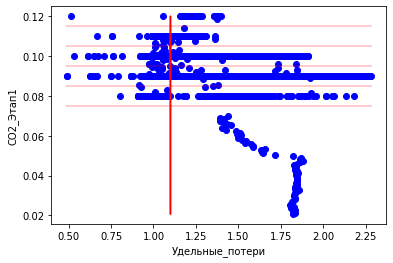

In [ ]:
plt.plot(df['Удельные_потери'].values, df['CO2_Этап1'].values, 'bo')
plt.plot([1.1]*len(df['CO2_Этап1']), df['CO2_Этап1'].values, 'r')
for j in np.arange (0.075, 0.115, 0.01):
    plt.plot( df['Удельные_потери'].values, [j]*len(df['CO2_Этап1']), 'r', alpha=0.2 )
plt.xlabel('Удельные_потери')
plt.ylabel('CO2_Этап1')
plt.show()

In [ ]:
df['CO2_Этап1_кат']=df['CO2_Этап1'].apply(lambda x:  '0.02-0.075' if x < 0.075 else  round(x, 2)     )
df['CO2_Этап1_кат'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.1           5741
0.09          5326
0.11           832
0.08           759
0.02-0.075      68
0.12            65
Name: CO2_Этап1_кат, dtype: int64

In [ ]:
df['H2_Этап1'][df['H2_Этап1']<65].value_counts()

1.210000     63
42.897561     1
9.099268      1
1.210244      1
1.237317      1
1.694634      1
Name: H2_Этап1, dtype: int64

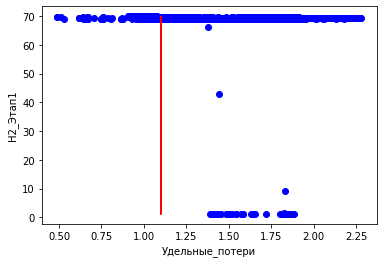

In [ ]:
for i in cat_param[4:5]:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.plot([1.1]*len(df[i]), df[i].values, 'r')
  #for j in np.arange (0.075, 0.115, 0.01):
    #plt.plot( df['Удельные_потери'].values, [j]*len(df[i]), 'r')
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

Здесь значений в районе нуля очень мало. И поскольку это очень низкие значения,скорее всего это либо ошибка измерения либо ошибка работы конвейера. Здесь необходимо уточнить у технолога. Но скорее всего это ошибки и мы можем считать эти данные выбросами и уберем эти значения из рассмотрения

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


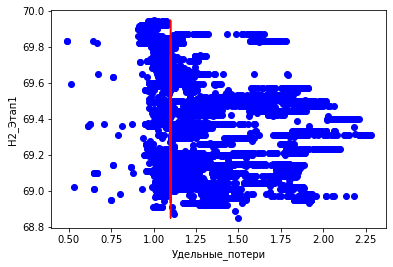

In [ ]:
df['H2_Этап1']=df['H2_Этап1'].apply(lambda x:  x if x > 68.5 else np.nan )
plt.plot(df['Удельные_потери'].values, df['H2_Этап1'].values, 'bo')
plt.plot([1.1]*len(df['H2_Этап1']), df['H2_Этап1'].values, 'r')
  
plt.xlabel('Удельные_потери')
plt.ylabel('H2_Этап1')
plt.show()

Здесь уже сложнее считать этот параметр категориальным, проще оставить его непрерывным числовым. Идем дальше

In [ ]:
#cat_param.remove ( 'H2_Этап1')
num_param.append('H2_Этап1')

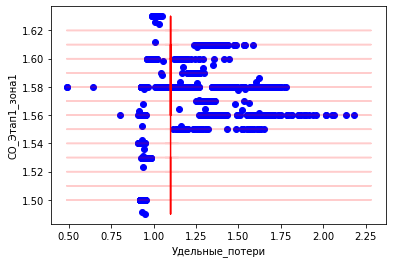

In [ ]:
for i in cat_param[5:6]:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.plot([1.1]*len(df[i]), df[i].values, 'r')
  for j in np.arange (1.5, 1.63, 0.01):
    plt.plot( df['Удельные_потери'].values, [j]*len(df[i]),  'r', alpha=0.2)
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

In [ ]:
df['CO_Этап1_зона1'].count()

1315

In [ ]:
df['CO_Этап1_зона1_кат']=df['CO_Этап1_зона1'].apply(lambda x:  '1.5-1.54' if x <= 1.545 else ( '1.61-1.62' if x > 1.61 else round(x, 2)))
df['CO_Этап1_зона1_кат'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1.58         346
1.56         295
1.5-1.54     207
1.6          119
1.61-1.62     71
1.57          71
1.55          70
1.59          70
1.61          66
Name: CO_Этап1_зона1_кат, dtype: int64

Очень мало значений, но зато есть некоторая зависимость. При занчениях параметра меньше 1.55 нет продукции низкого качества. Необходимо узнать у технолога о причине наличия пропущенных значений, и можно было бы проверить гипотезу о влиянии этого параметра на получение качественной продукции. К сожалению выборка слишком мала.

In [ ]:
#cat_param.remove ( 'CO_Этап1_зона1')

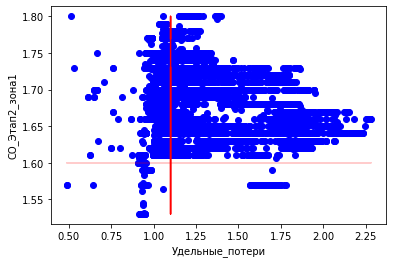

In [ ]:
for i in cat_param[6:7]:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.plot([1.1]*len(df[i]), df[i].values, 'r')
  plt.plot( df['Удельные_потери'].values, [1.6]*len(df[i]),  'r', alpha=0.2)
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

In [ ]:
df['CO_Этап2_зона1_кат']=df['CO_Этап2_зона1'].apply(lambda x:  '1.5-1.6' if x <= 1.6 else round(x, 2))
df['CO_Этап2_зона1_кат'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1.7        1238
1.73       1180
1.66       1133
1.68        957
1.65        944
1.64        917
1.67        853
1.63        735
1.72        665
1.62        662
1.69        624
1.71        568
1.61        546
1.75        490
1.74        401
1.5-1.6     271
1.77        247
1.78        198
1.8          66
1.79         66
1.76         30
Name: CO_Этап2_зона1_кат, dtype: int64

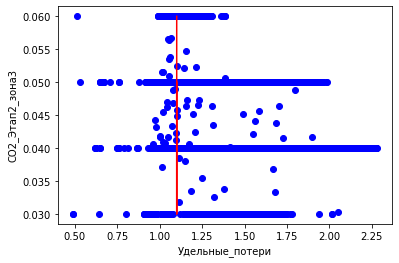

In [ ]:
for i in cat_param[7:8]:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.plot([1.1]*len(df[i]), df[i].values, 'r')
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

In [ ]:
df['CO2_Этап2_зона3_кат']=df['CO2_Этап2_зона3'].apply(lambda x:  round(x, 2))
df['CO2_Этап2_зона3_кат'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.04    5596
0.05    5549
0.03     935
0.06     711
Name: CO2_Этап2_зона3_кат, dtype: int64

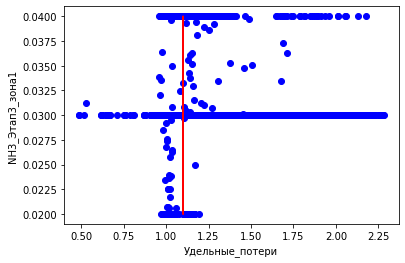

In [ ]:
for i in cat_param[8:9]:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.plot([1.1]*len(df[i]), df[i].values, 'r')
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

In [ ]:
df['NH3_Этап3_зона1_кат']=df['NH3_Этап3_зона1'].apply(lambda x:  round(x, 2) )
df['NH3_Этап3_зона1_кат'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.03    11627
0.04      819
0.02      345
Name: NH3_Этап3_зона1_кат, dtype: int64

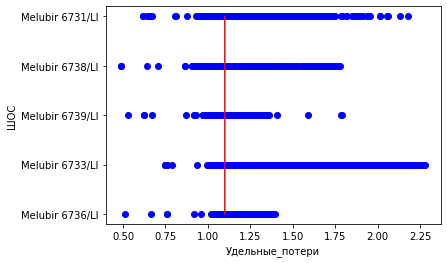

In [ ]:
for i in cat_param[9:10]:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.plot([1.1]*len(df[i]), df[i].values, 'r')
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

In [ ]:
cat_param = ['Время_проведенное_в_технологической_секции', 'Скорость_технологической_секции_кат','Время_нерперывного_отжига','CO2_Этап1_кат',
 'CO_Этап1_зона1_кат', 'CO_Этап2_зона1_кат', 'CO2_Этап2_зона3_кат', 'NH3_Этап3_зона1_кат']

num_param.append('H2_Этап1')


unuseful_param=unuseful_param+['Скорость_технологической_секции', 'CO2_Этап1', 'CO_Этап1_зона1', 'CO_Этап2_зона1', 'CO2_Этап2_зона3', 'NH3_Этап3_зона1']
unuseful_param

### Гипотеза 5 - Дейстительно ли использование веществ для обезуглероживания в  выбранных границах дает повышение количества качественной продукции?

Посмотрим на количественное распределение по выборкам очищенных категориальных параметров

Обезуглероживание


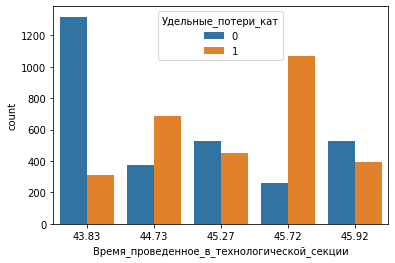

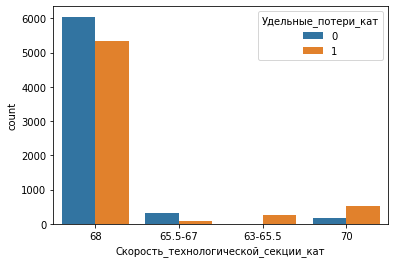

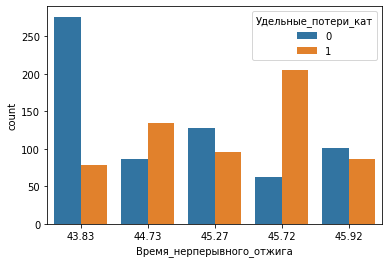

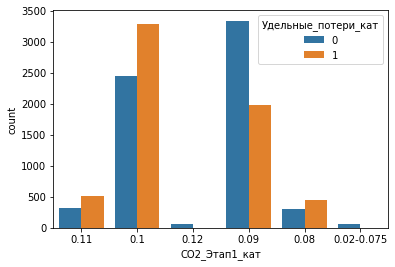

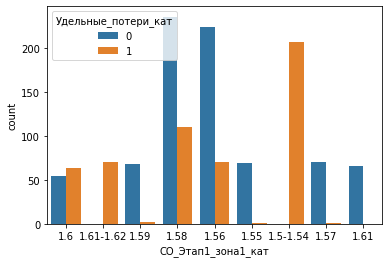

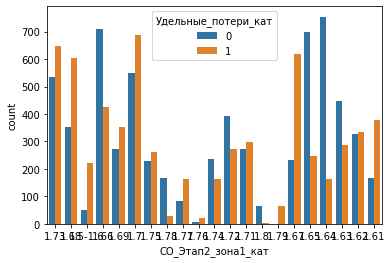

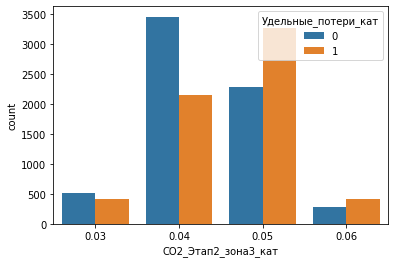

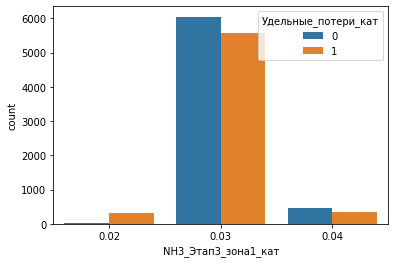

In [ ]:
print ('Обезуглероживание')
for i in cat_param:
  #print ('\n\n',i,'\n',  pd.get_dummies(df[i]).corrwith(df['Удельные_потери_кат'],  method='spearman') , '\n')
  sns.countplot(x=i, hue="Удельные_потери_кат", data=df)
  plt.show()

Здесь мы видим, что есть некоторые категории химических параметров и временных режимов, при которых качестенной продукции выпускается значительно больше и наоборот.

Визуально мы видим некоторые зависимости. Необходимо посчитать корреляцию.
Так как тут оцениваемые параметры и целевой параметр категориальные, то  будем рассчитывать корреляцию Крамера

In [ ]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

Проверим односторонную гипотезу H0: p1=p2 
что параметр N  не влияет на качество продукции. 
Против двухсторонней альтернативы H1: p1 <> p2 
, что изменение параметра N влияет на изменение целевого показателя.

И сразу проверим значимость корреляции криерием Хи-квадрат. Условия применения этого критерия выполняются: всего не менее 40 примеров и в каждой категории не менее 5 примеров.


In [ ]:
for i in cat_param :
  if i in unuseful_param:
      pass
  else:
    confusion_matrix = pd.crosstab(df [i], df['Удельные_потери_кат'])
    print( f"Корреляция Крамера для {i}: {cramers_v(confusion_matrix)}")
    chi2, p, dof, ex =stats.chi2_contingency(confusion_matrix)
    print(f"Проверка значимости корреляции Хи-криетрием chi2: {chi2} p-value: {p} \n\n")

Корреляция Крамера для Время_проведенное_в_технологической_секции: 0.454020449539797
Проверка значимости корреляции Хи-криетрием chi2: 1225.1418248112204 p-value: 5.6454391491431275e-264 


Корреляция Крамера для Скорость_технологической_секции_кат: 0.2151013662623421
Проверка значимости корреляции Хи-криетрием chi2: 594.7755963924649 p-value: 1.367619358439978e-128 


Корреляция Крамера для Время_нерперывного_отжига: 0.39593575981858165
Проверка значимости корреляции Хи-криетрием chi2: 200.2730073071202 p-value: 3.282290093055011e-42 


Корреляция Крамера для CO2_Этап1_кат: 0.22514966730615255
Проверка значимости корреляции Хи-криетрием chi2: 653.3558336474066 p-value: 5.958259859251496e-139 


Корреляция Крамера для CO_Этап1_зона1_кат: 0.69275904160562
Проверка значимости корреляции Хи-криетрием chi2: 638.6141509482839 p-value: 1.162144578210768e-132 


Корреляция Крамера для CO_Этап2_зона1_кат: 0.33460690029234946
Проверка значимости корреляции Хи-криетрием chi2: 1451.992692048227 p

Высоких значений p-value нет, все вычисленные корреляции значимы.

ЗДесь стоит отметить что разница в значениях (расстояния между значениями, например 0.11 и 0.12) настолкьо малы, что есть сомнение в возможности установить такие жесткие ограничения. 

Кроме того, нужно проследить путь каждого рулона на каждом подэтапе до конечной продукции и попытаться определить и оценить совметное последовательное влияние параметров (можно использовать регрессию)

## Химия итог

Химия итог


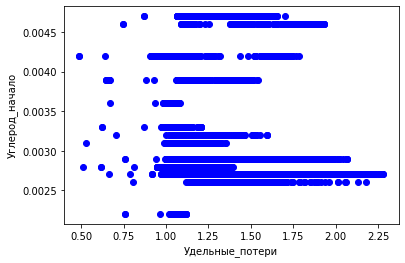

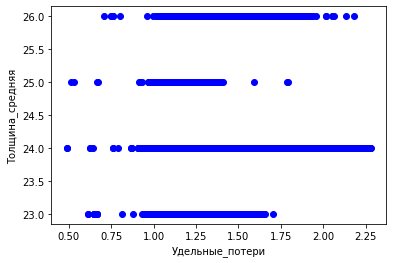

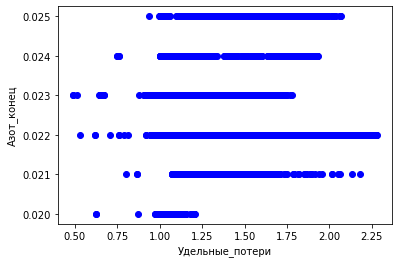

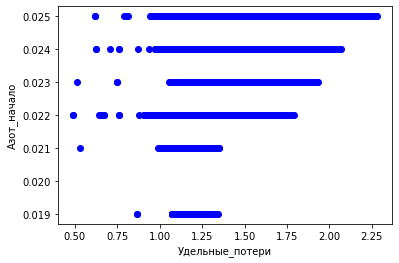

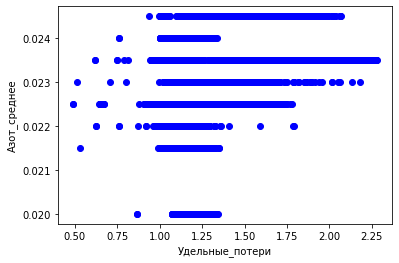

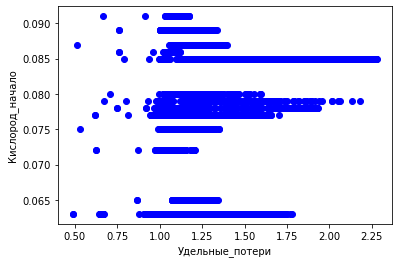

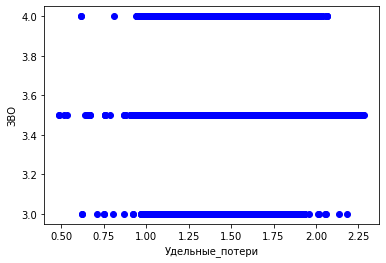

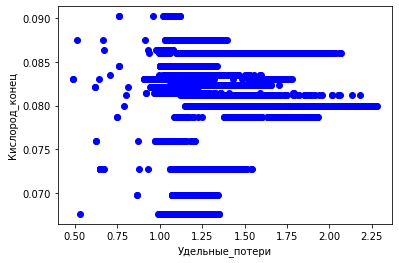

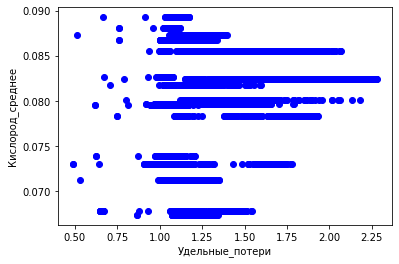

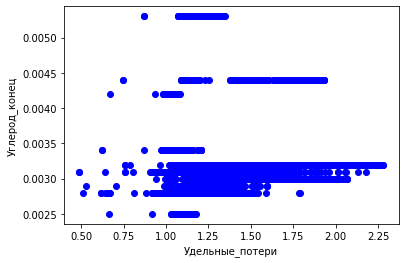

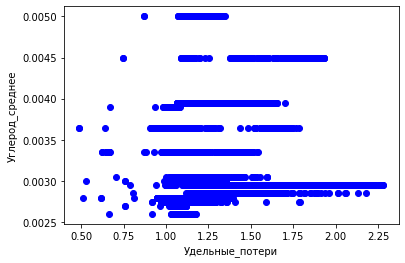

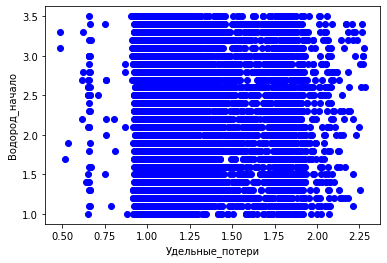

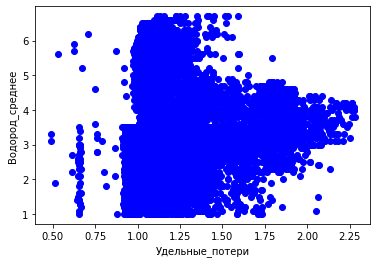

In [ ]:
print ('Химия итог')
for i in stages['Химия итог']:
  plt.plot(df['Удельные_потери'].values, df[i].values, 'bo')
  plt.xlabel('Удельные_потери')
  plt.ylabel(i)
  plt.show()

Все показатели категориальные, кроме Водрод_среднее.

Вопрос : Что значит 'Углерод_начало' и 'Углерод_конец' вроде в описании указано, что это Итоговый химический анализ рулона? Где или когда берутся эти измерения?


#Get important parameters and stages

Теперь я считаю, что необходимо анализировать категориальный вариант параметра "Удельные потери" , где 1, если показатель < 1.1 и 0, если выше и

1. считать корреляцию Крамера для категориальных параметров 

2. разницу между математическими ожиданиями распределения непрерывного параметра при удельных потерях ==1 и == 0 соответственно

### Parameters correlation

In [ ]:
cat_param = ['Время_проведенное_в_технологической_секции', 'Скорость_технологической_секции_кат','Время_нерперывного_отжига','CO2_Этап1_кат',
 'CO_Этап1_зона1_кат', 'CO_Этап2_зона1_кат', 'CO2_Этап2_зона3_кат', 'NH3_Этап3_зона1_кат']
cat_param= cat_param+(stages['Химия плавки'] )
cat_param=[i for i in cat_param if i not in unuseful_param]

num_param=list(param['Название параметра'][param['Номер пп'].isin(list(range(1,6)))].unique())
num_param= [ i for i in num_param if i not in cat_param + unuseful_param ]
#num_param.append('H2_Этап1')
'H2_Этап1' in num_param


True

In [ ]:
df['Время_нерперывного_отжига']= df['Время_нерперывного_отжига'].apply(lambda x: round(x,2))
df['Время_проведенное_в_технологической_секции']= df['Время_проведенное_в_технологической_секции'].apply(lambda x: round(x,2))
df['Скорость_технологической_секции_кат']=df['Скорость_технологической_секции'].apply(lambda x:  '63-65.5' if x < 65.5 else( '65.5-67' if x <67 else( '70' if x > 69.5  else '68')  )         )
df['CO2_Этап1_кат']=df['CO2_Этап1'].apply(lambda x:  '0.02-0.075' if x < 0.075 else  round(x, 2)     )
df['H2_Этап1']=df['H2_Этап1'].apply(lambda x:  x if x > 68.5 else np.nan )
df['CO_Этап1_зона1_кат']=df['CO_Этап1_зона1'].apply(lambda x:  '1.5-1.54' if x <= 1.545 else ( '1.61-1.62' if x > 1.61 else round(x, 2)))
df['CO_Этап2_зона1_кат']=df['CO_Этап2_зона1'].apply(lambda x:  '1.5-1.6' if x <= 1.6 else round(x, 2))
df['CO2_Этап2_зона3_кат']=df['CO2_Этап2_зона3'].apply(lambda x:  round(x, 2))
df['NH3_Этап3_зона1_кат']=df['NH3_Этап3_зона1'].apply(lambda x:  round(x, 2) )


В ячейке выше посчитано примерное относительное влияние каждого из параметров на основе разницы средних:
https://colab.research.google.com/drive/1aHWuDgqt_uuMI31sVJSsu0DNV-NMP6IP#scrollTo=ptojf5NLpt1E&line=2&uniqifier=1

Используем этот результат для оценки важности вклада непрерывных числовых показателей:

### **The most important continual numerical parameters:**

In [ ]:
"""scaler = StandardScaler()
df_scaler = pd.DataFrame(columns=df[num_param].columns,  data=scaler.fit_transform(df[num_param]) )
df_num_quality=pd.concat([df_scaler [num_param] [df['Удельные_потери_кат'] ==0 ].mean(), df_scaler [num_param] [df['Удельные_потери_кат'] ==1 ].mean()], axis=1 )
df_num_quality['diff']=abs(df_num_quality[0]-df_num_quality[1])
df_num_quality.sort_values('diff', ascending=False, inplace=True)#[df_quality['diff']>1]
print(df_num_quality)"""

In [ ]:
df_quality.loc[num_param, :].sort_values('diff', ascending=False)

,0,1,diff
Точка_росы_Этап1_зона1,-0.412990,0.493032,0.906022
T_конца_проката,-0.356240,0.373995,0.730234
H2_Этап2_зона2,-0.323777,0.339914,0.663690
T_проход_3,-0.312110,0.327666,0.639776
H2_Этап2_зона1,-0.293313,0.307932,0.601245
...,...,...,...
Длина_Азотирование,-0.003822,0.004012,0.007834
Т_Этап5_зона1,-0.002885,0.003029,0.005915
Настройка_датчика_CO2_Этап2_зона4,0.001932,-0.002028,0.003960
Скорость_технологической_секции,-0.001301,0.001366,0.002667


### **The most important continual categorical parameters:**

В ячейках выше обоснован расчет корреляции категориальных параметров к целевому показателю:
https://colab.research.google.com/drive/1aHWuDgqt_uuMI31sVJSsu0DNV-NMP6IP#scrollTo=yMopOHjO98rf&line=4&uniqifier=1  


Используем этот результат для оценки важности вклада категориальных показателей:

In [ ]:
def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [ ]:
df_cat_quality=pd.DataFrame(index=cat_param, columns=['Corr'])
df_cat_quality['Corr']= [ cramers_v(pd.crosstab(df [i], df['Удельные_потери_кат'])) for i in cat_param]
 
df_cat_quality.sort_values('Corr', ascending=False, inplace=True)
df_cat_quality

,Corr
CO_Этап1_зона1_кат,0.692759
Время_проведенное_в_технологической_секции,0.454020
ШОС,0.436840
Si,0.436840
N,0.436835
Al,0.400151
Время_нерперывного_отжига,0.395936
Cr,0.383334
F,0.354483
CO_Этап2_зона1_кат,0.334607


### Stages correlation

I think here necessary to estimate by median for to account for outliers

In [ ]:
print ('Have a look on the correlation Stages with the target parameter: Удельные_потери \n' )
importance_stages=pd.DataFrame(index=stages.keys(), columns=['median', 'mean', 'min', 'max'])
for stage in ['Холодный прокат', 'Нормализация','Горячий прокат']:
  x=df[stages[stage]].corrwith( df['Удельные_потери'])
  importance_stages['median'][stage]=x.median()
  importance_stages['mean'][stage]=x.mean()
  importance_stages['min'][stage]=x.min()
  importance_stages['max'][stage]=x.max()
importance_stages  

Have a look on the correlation Stages with the target parameter: Удельные_потери 



,median,mean,min,max
Горячий прокат,0.0700617,0.000676421,-0.32147,0.132616
Нормализация,-0.00181562,0.0202483,-0.0152398,0.119369
Обезуглероживание,NaN,NaN,NaN,NaN
Химия плавки,NaN,NaN,NaN,NaN
Холодный прокат,-0.131035,-0.119558,-0.376231,0.106784
Химия итог,NaN,NaN,NaN,NaN


In [ ]:
print ('Have a look on the correlation with the target parameter: Удельные_потери \n' )
importance_decarbon=pd.DataFrame(index=decarbonization['Этап_обезуглероживания'].unique() , columns=['median', 'mean', 'min', 'max'])
for p in [decarbonization['Этап_обезуглероживания'].unique()]:
  
  x=  df[decarbonization['Название параметра'] [ decarbonization['Этап_обезуглероживания'].isin(p) ].to_list()] .corrwith( df['Удельные_потери'] )
  importance_decarbon['median'][p]=x.median()
  importance_decarbon['mean'][p]=x.mean()
  importance_decarbon['min'][p]=x.min()
  importance_decarbon['max'][p]=x.max()
importance_decarbon  

Have a look on the correlation with the target parameter: Удельные_потери 



,median,mean,min,max
0,-0.00545742,-0.0670091,-0.705928,0.175156
1,-0.00545742,-0.0670091,-0.705928,0.175156
2,-0.00545742,-0.0670091,-0.705928,0.175156
3,-0.00545742,-0.0670091,-0.705928,0.175156
4,-0.00545742,-0.0670091,-0.705928,0.175156
5,-0.00545742,-0.0670091,-0.705928,0.175156


# Detection and delete collinearity features 

Seaborn visualisation the correlation

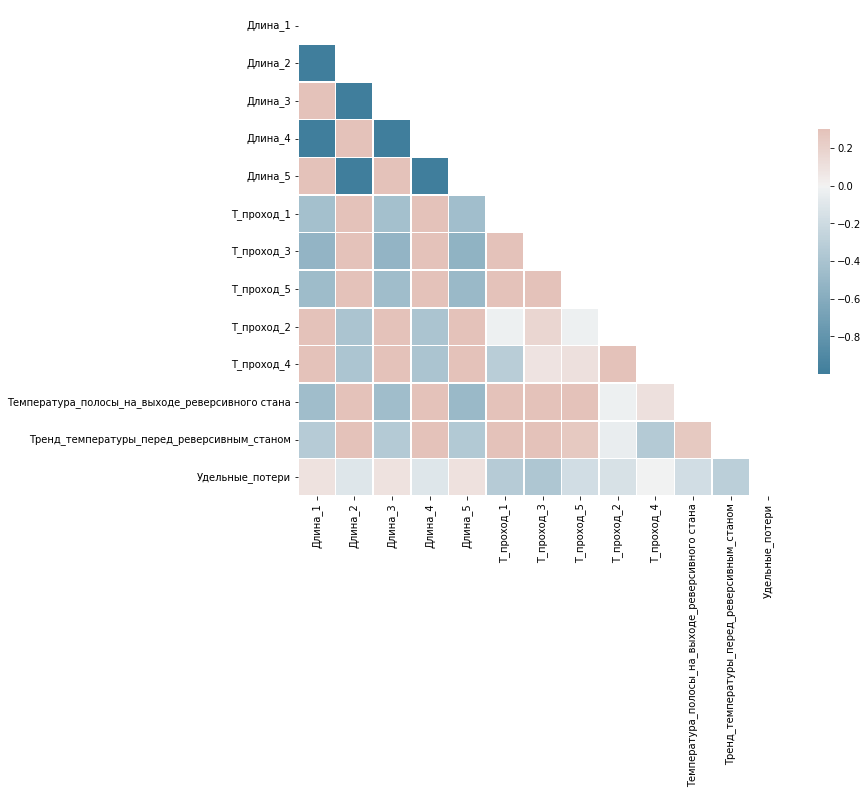

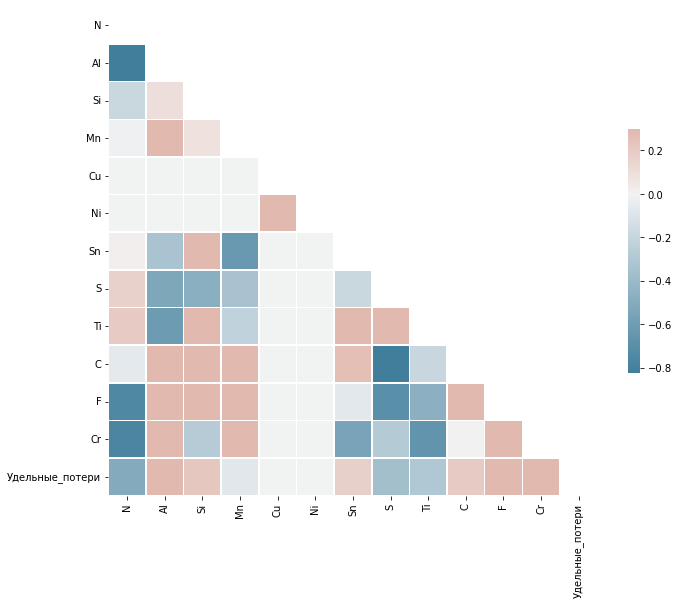

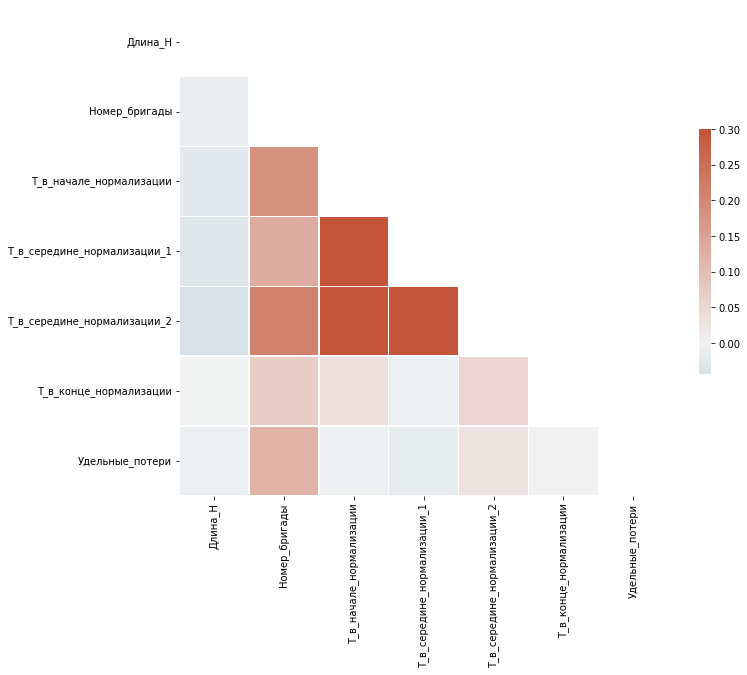

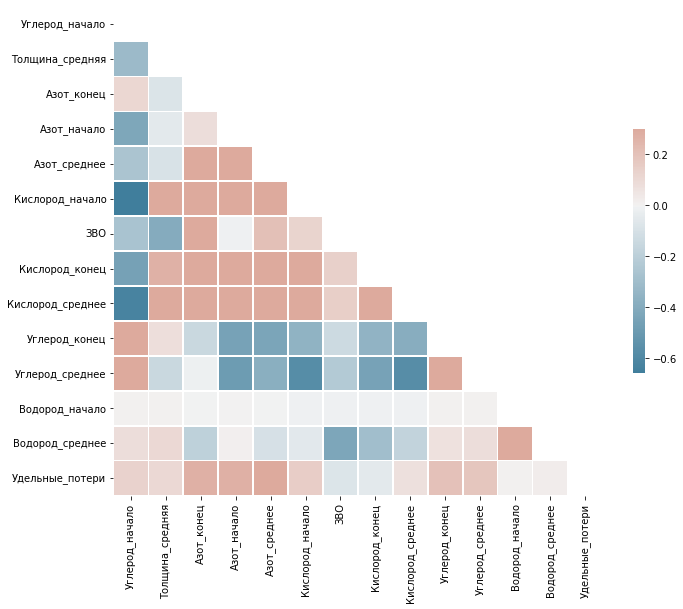

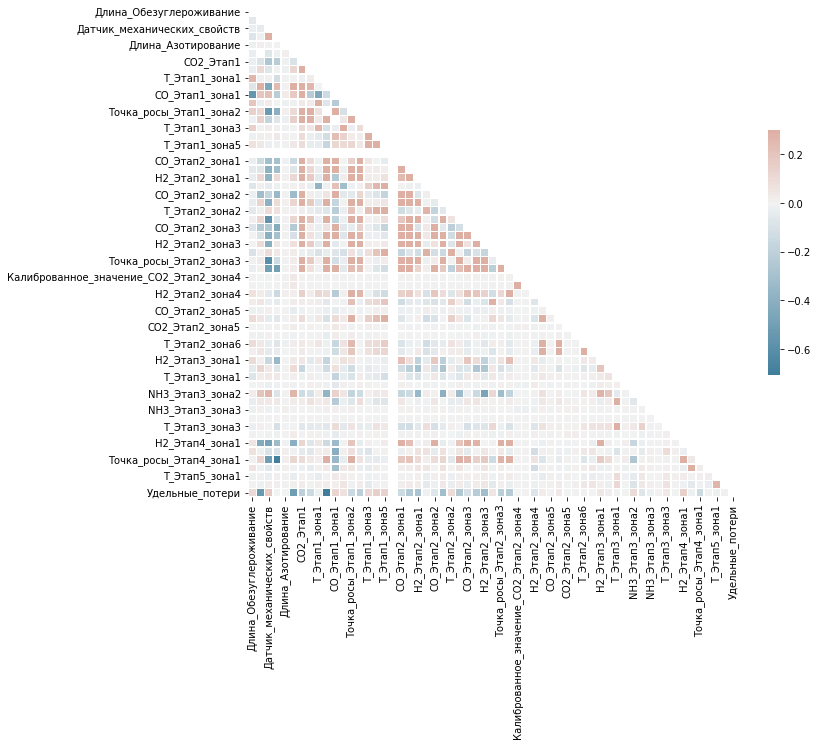

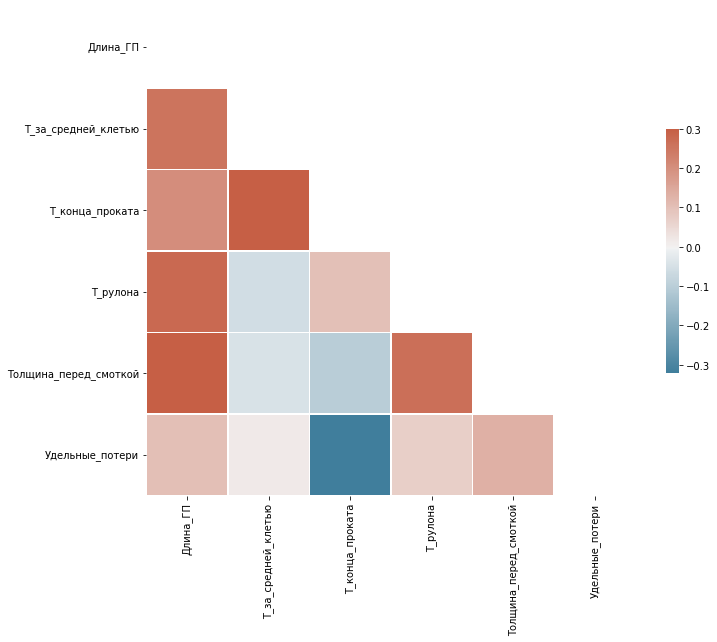

In [ ]:
for stage in stages:
    
 

    # Compute the correlation matrix
    corr = df[stages[stage]+['Удельные_потери']].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Сonclusions

**Гипотеза 1** Да, доля качественной и некачественной продукции значимо отличается для части химических показателей плавки.
Список важных:

ЗДесь стоит отметить что разница в значениях (расстояния между значениями, например 0.11 и 0.12) настолкьо малы, что есть сомнение в возможности установить такие жесткие ограничения на используемый для плавки материал.

*Вопрос к технологу: *Можно ли установить более жесткие требования к химическому составу метариала для плавки с точностью до десятых и сотых?

Кроме того, можно проследить путь каждого сляба от плавки до конечной продукции и попытаться определить и оценить совметное последовательное влияние параметров(регрессия).

Важность параметров на этом этапе:
https://colab.research.google.com/drive/1aHWuDgqt_uuMI31sVJSsu0DNV-NMP6IP#scrollTo=yMopOHjO98rf&line=9&uniqifier=1


**Гипотеза 2.1 / 3.1** Да, средние температуры отличаются для качественной и некачественной продукции, кроме последнего прохода.
Список важных:

*Вопрос к технологу: *Возможно ли удерживать температуру горячего проката и нормализации с точностью до пяти градусов, до градуса?

**Гипотеза 2.2 / 3.2** 
Необходимо построить линейную регрессию, чтобы проверить предсказательную силу параметра "Длина" с учетом влияния на результат всех остальных параметров.

*Вопрос к технологу:* (Не нашла в интернете) На практике рулоны выпускаются одинаковой толщины? Факт что более крупные детали остывают и нагреваются медленнее, значит размер может влиять на температуру рулона. Но влияет ли только толщина рулона или другие два измерения тоже оказываются влияние? Интересует мнение специалиста-практика.

Если окажется что на скорость изменения температуры внутри рулона влияет не только толщина, но и другие геометрические размеры, тогда второй вопрос: Может ли нарезка на рулоны осуществляться последим этапом? Что проще и дешевле - регулировать температуру или нарезку рулонов?



**Гипотеза 4.1** Да, средние температуры отличаются для качественной и некачественной продукции, кроме последнего прохода.
Список важных:

*Вопрос к технологу:* Возможно ли удерживать температуру холодного проката и нормализации с точностью до десяти градусов?
Что за 4 длины? Размеры изменяются после проходов?


**Рейтинг важности всех непрерывных числовых параметров:**

In [ ]:
#Важность непрерывных числовых параметров:
df_quality.loc[num_param, ['diff']].sort_values('diff', ascending=False)

,diff
Точка_росы_Этап1_зона1,0.906022
T_конца_проката,0.730234
H2_Этап2_зона2,0.663690
T_проход_3,0.639776
H2_Этап2_зона1,0.601245
...,...
Длина_Азотирование,0.007834
Т_Этап5_зона1,0.005915
Настройка_датчика_CO2_Этап2_зона4,0.003960
Скорость_технологической_секции,0.002667


**Гипотеза 5** Много категориальных переменных. Да, использование веществ в выбранных границах дает повышение качества продукции. Почти все категориальные переменные, нуждались в очистке от выбросов (сделано).
Наиболее важные: https://colab.research.google.com/drive/1aHWuDgqt_uuMI31sVJSsu0DNV-NMP6IP#scrollTo=RwYw0J3xtda0&line=5&uniqifier=1


H2_Этап1 - Здесь значений в районе нуля очень мало. И поскольку это очень низкие значения,скорее всего это либо ошибка измерения либо ошибка работы конвейера. Здесь необходимо уточнить у технолога. Но скорее всего это ошибки и мы можем считать эти данные выбросами и уберем эти значения из рассмотрения

CO_Этап1_зона1 -Очень мало значений, но зато есть некоторая зависимость. При занчениях параметра меньше 1.55 нет продукции низкого качества. Необходимо узнать у технолога о причине наличия пропущенных значений, и можно было бы проверить гипотезу о влиянии этого параметра на получение качественной продукции. К сожалению выборка слишком мала.


**Рейтинг всех категориальных параметров:**

In [ ]:
df_cat_quality

,Corr
CO_Этап1_зона1_кат,0.692759
Время_проведенное_в_технологической_секции,0.454020
ШОС,0.436840
Si,0.436840
N,0.436835
Al,0.400151
Время_нерперывного_отжига,0.395936
Cr,0.383334
F,0.354483
CO_Этап2_зона1_кат,0.334607


## Suggestions

Важные этапы которые были упущены: 
- оценка последовательного влияния параметров на увеличение количества качественной продукции (условная корреляция)

- оценка 



Отбор наиболее полезных признаков для ML можно осуществить также